## Análise 01 - Filtros Ativos com Amplificadores Operacionais

* Alejo P. Milar
* João Mário C. I. Lago

### Eletrônica III (2023.1 - T01)

<hr />

### Packages

In [15]:
!pip -q install quantiphy numpy sympy pandas matplotlib control


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import control
import pandas as pd
from quantiphy import Quantity
from typing import List, Optional

<hr />

### Utils 

Definição de funções auxiliares para realização de alguns cálculos realizados durante a execução do trabalho

In [17]:
# Prints a given parameter with its unit and using multipliers
def print_param(name: str, value: float, unit: str = "") -> None:
	print(name + ": " + str(Quantity(value, unit)))


# Converts a log value to a linear value
def log_2_linear(gain: float) -> float:
	return 10.0 ** (gain / 20.0)


# Converts a linear value to a log value
def linear_2_log(gain: float) -> float:
	return 20.0 * np.log10(gain)


# Commercial EE values list
def get_EE_list(limit: int = 21, lower = 0, pack: Optional[ List[ float ] ] = None) -> List[ float ]:
	return [x * (10 ** i) for i in range(pack[1] if pack else lower, pack[0] if pack else limit) for x in [ 1.5e-12, 1.8e-12, 2.2e-12, 2.7e-12, 3.3e-12, 4.7e-12, 5.1e-12, 6.8e-12, 7.5e-12, 8.2e-12, 9.1e-12, 10e-12 ]]


def get_EE_limit_from_value(value: float) -> List[ int ]:
	order = np.floor(np.log10(value))
	return [ int(13 + order), int((13 + order) - 1) ] 


# Find the best fit for the closest comercial value in the EE list
def round_to_commercial(value: float) -> float:
	EE: List[ float ] = get_EE_list()
	index: int = 0
	close: float = np.inf
	for i, val in enumerate(EE):
		diff = val - value
		if np.abs(diff) < close:
			close = np.abs(diff)
			index = i
	return EE[index]


# Get the gain in the passing band
def get_gain(df: pd.DataFrame, col: str) -> np.float64:
	return df[col].max()


# Get the gain in the passing band
def get_gain_in_range(df: pd.DataFrame, col: str, f: float, t: float) -> np.float64:
	return df[col][f:t].max()


# Get the frequency with gain -3db of the passing band gain
def get_cutoff_frequency(df: pd.DataFrame, col: str) -> np.float64:
	# Get gains
	gain = get_gain(df, col)
	cutoff_gain = gain - 3
	index = df.index.name
	df = df.reset_index()
	# Get the two values nearest to the cutoff gain and get the frequency
	cutoff_frequencies = df.iloc[(df[col] - cutoff_gain).abs().argsort()[:2]][index]
	# Return the minimum cutoff frequency
	return cutoff_frequencies.min()


# Get the frequency with gain -3db of the passing band gain
def get_cutoff_frequency_in_range(df: pd.DataFrame, col: str, f: float, t: float) -> np.float64:
	# Get gains
	gain = get_gain_in_range(df, col, f, t)
	cutoff_gain = gain - 3
	index = df.index.name
	df = df.reset_index()
	# Get the two values nearest to the cutoff gain and get the frequency
	cutoff_frequencies = df.iloc[(df[col] - cutoff_gain).abs().argsort()[:2]][index]
	# Return the minimum cutoff frequency
	return cutoff_frequencies.min()


# Get the gain in the cutoff frequency
def get_cutoff_gain(gain: float) -> float:
	return gain - 3.0


# Create the transfer function of a theorical high pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n1_high_pass_filter(freq: float, gain: float) -> control.TransferFunction:
	w0 = (2 * np.pi * freq)
	'''
		High pass filter transfer function 
		gain * s / 1 + w0
	'''
	num = [gain, 0]
	den = [1, w0]
	return control.TransferFunction(num, den)


# Create the transfer function of a theoretical low pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n1_low_pass_filter(freq: float, gain: float) -> control.TransferFunction:
	w0 = (2 * np.pi * freq)
	'''
		High pass filter transfer function 
		gain * w0 / (s + w0)
	'''
	num = [0, gain]
	den = [1 / w0, 1]
	return control.TransferFunction(num, den)


# Get the attenuation ratio of a pandas dataframe containing 
# one of the desired curves of the test
def get_attenuation_ratio(df: pd.DataFrame, gain: str, high_pass: bool = True) -> float:
	cutoff_frequency = get_cutoff_frequency(df, gain)
	# use values under 50% of the cutoff frequency to reduce the error because of the transition
	df_temp = df[df.index < (cutoff_frequency * 0.5)] if high_pass else df[df.index > (cutoff_frequency * 0.5)]
	index = df_temp.index.name
	df_temp = df_temp.reset_index()
	return np.abs((df_temp[gain].diff() / np.log10(df_temp[index]).diff()).mean())

# Get the attenuation ratio of a pandas dataframe containing 
# one of the desired curves of the test
# gain: name of the gain column
# limits: list containing lower and upper limits [lower, upper]
def get_attenuation_ratio_in_range(df: pd.DataFrame, gain: str, lower: float, upper: float) -> float:
	cutoff_frequency = get_cutoff_frequency(df, gain)
	df_temp = df[df.index > lower]
	df_temp = df_temp[df_temp.index < upper]
	index = df_temp.index.name
	df_temp = df_temp.reset_index()
	return np.abs((df_temp[gain].diff() / np.log10(df_temp[index]).diff()).mean())


# Create the transfer function of a theoretical high pass filter
# @param freq cutoff frequency
# @param gain in the passing band
def get_n3_low_pass_filter(freq: float, gain: float, Q: float) -> control.TransferFunction:
	w1 = (2 * np.pi * freq)
	w2 = (2 * np.pi * freq)
	'''
		https://habr.com/en/post/542496/
		Low pass filter transfer function 3° Order 
								A                                 A                                 A
		H(s) = ————————————————————————— = ————————————————————————————————————— = ———————————————————————————
			(1 + a s)(1 + b s + c s²)   1 + (a + b) s + (a b + c) s² + a c s³   1 + ps1 s + ps2 s² + ps3 s³

		ps1 = 1 / ω₁ + 1 / (Q ω₂)
		ps2 = 1 / (ω₁ Q ω₂) + 1/ω₂²
		ps3 = 1 / (ω₁ ω₂²)
	'''
	ps1 = (1 / (w1 + 1)) / (Q * w2)
	ps2 = (1 / (w1 * Q * w2)) + (1 / (w2 ** 2))
	ps3 = 1 / (w1 * (w2 ** 2))
	num = [0, gain]
	den = [ps3, ps2, ps1, 1]
	return control.TransferFunction(num, den)


<hr />

### Definição do Capacitor Sugerido de referência segundo a tabela de projeto

O Capacitor sugerido é definido segundo a tabela de projetos fornecida na disciplina e desenvolvida com base no livro (DEFINIR) referenciado no final do documento.

Valor do capacitor é (10 / fc) uF. Onde fc é a frequência de corte desejada do filtro sendo projetado

<img src="./assets/imgs/sld_4_0.png" />

### Observações sobre a escolha do capacitor

Conforme a tabela de projetos fornecida, o recomendado seria a utilização de um capacitor base sendo dado por (10 / fc) uF. No nosso experimento, vale a pena deixar claro que, apesar de o valor de referência ter sido calculado, foi feito a escolha de um capacitor base que forneceria um erro da escolha dos outros componentes com o menor erro dos valores comerciais, porém se mantendo próximo do valor de "chute" inicial recomendado pela tabela de projetos fornecida na disciplina.

<p style="color: red;">Seja cauteloso e tenha bom senso na escolha desse capacitor, valores extremos tendem a fazer a implementação do projeto inviável devido a parasitas gerados no circuito</p>

### Seletor de valores comercial usado

O seletor de valores se baseia na utilização da lista de componentes EE todos usando multiplicador padrão e^-12, então pode-se pegar a lista de componentes até uma certa potência desejada.

O valor é selecionado automaticamente usando a potência do valor do capacitor sugerido pelo cálculo 10 / fc, com essa potência é feito a seleção usando a potência base até a potência base + 1. Por exemplo, se o capacitor sugerido for 10nF, o capacitor escolhido estará no range de 1nF até 100nF.

<p style="color: red;">Tenha cuidado de analisar se o capacitor sugerido for muito grande já de início, por exemplo, na casa de uF, caso o sugerido seja 10uF, o selecionado pelo código poderá ser entre 1uF até 100uF, ou seja, não será viável para implementação prática pois poderá ser muito grande.</p>

<hr />

### Sobre o termo usado no trabalho referente as "Frequências comerciais"

Para o cálculo das frequências comercias, foi feito o re-cálculo das frequências de corte a partir dos valores arredondados para os valores comerciais após a seleção automatica orcorrer pelo software, isso determina a frequência de corte efetiva que era buscada na prática com o arredondamento para valores comerciais, vale ressaltar que não será provavelmente a frequência buscada inicialmente, por exemplo, caso a frequência ideal for 230Hz, tem grandes chances de a frequência com os valores comerciais com menor erro no range próximo ao capacitor sugerido ser de por exemplo 233Hz. Logo 233Hz é uma das frequências referidas no trabalho a seguir como "frequências comerciais". Quanto aos valores de frequências MIN e MAX, se referem ao cálculo da frequencia de corte utilizando as tolerâncias dos componentes em seus piores casos, logo, resitores +- 5% e capacitores +-10%.
Por exemplo, se a frequência comercial for de 233Hz, pode-se recalcular a frequencia para os casos onde os resistores e capacitores tiverem seu maior erro, tanto para mais quanto para menos, isso gera as frequências MIN e MAX que pode-se esperar que ocorra na montagem prática.

<img src="./assets/imgs/sld_8_0.png" />

<hr />

### Circuitos e Análises

<hr />

#### 1- Filtro passa-alta de primeira ordem [gain = 3, cut = 230Hz] (VCVS)

### Requisitos de projeto

* Frequência de corte desejada: 230Hz
* Ganho linear: 3
* Topologia usada VCVS (Escolhida por não ser inversora)

### Circuito


**Foi escolhido de apresentar o circuito projeto implementado no LTSpice antes do código que realiza o cálculo efetivo dos componentes, o que a primeira vista pode aparentar não ser muito logico pois é necessário calcular os componentes antes e se realizar a implementação do circuito, porém, para o leitor faz mais sentido apresentar o circuito anteriomente pois este precisa saber o circuito para fazer a sua análise e consequentemente entender o código que realiza seu cálculo a seguir. Mas mantenha em mente que a equipe primeiro realizou a análise e utilizando a tabela de projeto desenvolveu o codigo que executa o cálculo dos componentes para apenas depois fazer sua implementação no LTSpice e sequente adaptações, mas por viés de compreensão a imagem da implementação do projeto foi apresentada antes para o leitor ter uma orientação melhor sobre a que tipo de circuito o código se  refere. A mesma observação vale para os subsequentes projetos (2, 3 e 4).**


<img src="./analises/1/1.png"/>

<hr/>

### Analise teorica

In [18]:
# 1 - Projetar e simular um filtro passa-alta de primeira ordem [gain = 3, cut = 230Hz]

# Cut frequency in Hz
fc: float = 230

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 3

# First order
b: float = 1

print("------------------------------------------------------------------")
C_suggested = (10.0 / fc) * 1e-6
print_param("Capacitor Sugerido", C_suggested, "F")

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for C in get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = b / (wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print_param("Capacitor escolhido", C, "F")
print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("    - Ideal R1", R1, "Ω")
print_param("    - Ideal R2", R2, "Ω")
print_param("    - Ideal R3", R3, "Ω")
print()
print_param("    - Comercial R1", R1_commercial, "Ω")
print_param("    - Comercial R2", R2_commercial, "Ω")
print_param("    - Comercial R3", R3_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("    - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print("    - Comercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print("------------------------------------------------------------------")
print_param("Valor de frequência comercial      ", FC_commercial, "Hz")
print_param("Valor de frequência comercial (MIN)", FC_commercial_min, "Hz")
print_param("Valor de frequência comercial (MAX)", FC_commercial_max, "Hz")
print("------------------------------------------------------------------")

------------------------------------------------------------------
Capacitor Sugerido: 43.478 nF
Capacitor escolhido: 100 nF
------------------------------------------------------------------
Parâmetros do circuito: 
    - Ideal R1: 6.9198 kΩ
    - Ideal R2: 10.38 kΩ
    - Ideal R3: 20.759 kΩ

    - Comercial R1: 6.8 kΩ
    - Comercial R2: 10 kΩ
    - Comercial R3: 22 kΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
    - Ideal:
	.param C=100n R1=6.9198k R2=10.38k R3=20.759k
    - Comercial:
	.param C=100n R1=6.8k R2=10k R3=22k
------------------------------------------------------------------
Valor de frequência comercial      : 234.05 Hz
Valor de frequência comercial (MIN): 202.64 Hz
Valor de frequência comercial (MAX): 273.74 Hz
------------------------------------------------------------------


### Dos parâmetros do projeto

Como pode ser observado, idealmente os componentes ideais para ser utilizado seriam os valores de:
* Ideal  C: 100 nF
* Ideal R1: 6.9198 kΩ
* Ideal R2: 10.38 kΩ
* Ideal R3: 20.759 kΩ

Essa combinação de componentes irá gerar a frequência de corte esperada de 230Hz e o ganho linear de 3. Porém os componenetes comerciais mais próximos são os de valores.
* Comercial  C: 100 nF
* Comercial R1: 6.8 kΩ
* Comercial R2: 10 kΩ
* Comercial R3: 22 kΩ

Isso acaba resultando em uma nova frequência de corte de 234.05Hz. Vale ressaltar que dependendo da aplicação essa divergência não é tolerável, logo seria necessário a geração de associações para fazer os valores ideais, ou mesmo a compra de componentes de precisão ou utilização de um trimpot, a escolha final depende do contexto, do valor agregado do produto e outros parãmetros. Alguns pontos a serem considerados nessa escolha são o seguinte:
* Utilização de um trimpot permite atingir precisões altas, porém este necessita que na linha de produção exista a calibragem do aparelho que terá de se realizado por algum humano ou maquina, mas que irá tornar o processo mais caro, porém tem de se lembrar que dependendo do aparelho, o trimpot será uma boa escolha pois se a vida util do aparelho for longa, isso permite sua calibração depois de um longo período de operação, assim fornecendo uma utilização viável do equipamento por longos períodos de tempo, mas sendo mais caro e mais trabalhoso de produzir.
* Associação de componentes pode ser viável, mas é necessário lembrar que isso aumenta o espaço necessário, caso peso seja crítico na aplicação pode incrementar o peso final do produto, pois será necessário normalmente mais área de placa e mais componentes, bem como deixa o produto mais caro pela necessidade de mais componentes. E por fim, tem de se levar em conta que associar componenetes de baixa precisão ainda poderá gerar erros que precisam serem levados em conta.
* Componenetes de precisão, normalmente são uma boa escolha pois não (normalmente) associações e conseguem valores mais próximos, porém tendem a ser mais caros.

Logo, a escolha final depende muito do projeto sendo realizado e seu propósito, bem como valor agregado etc...

Como o circuito do projeto 1 foi implementado na prática, e a equipe desejava mais verificar o comportamento do circuito, não foi feito a utilização das técnicas mencionadas a seguir, logo, foi utilizado o valor com o arreedondamento comercial com menor erro, logo a nova frequência de corte passou a ser o valor de 234.05Hz, e como poderá ser observado a nas análises a seguir, o erro ocorrido foi relativamente grande, como esperado e que será demonstrado a seguir.

<hr />

### Análise do comportamento do circuito na simulação realizada no LTSpice

Vale fazer uma observação nesse ponto que será evidenciada novamente nas análises práticas que virão nos gráficos mais a baixo. A equipe cometeu um erro que deve ser observado aqui, todas simulações foram realizadas utilizando valores ideais, logo as frequências que foram utilizadas nas simulações foram de 230Hz, porém como mencionado a cima e que será evidenciado posteriormente, a prática foi feita com um circuito de 234.05Hz, logo, a simulação oferece uma boa noção porém se trata de um circuito diferente do implementado na prática.

Segunda observação, todas as simulações foram realizadas utilizando os componentes ideiais, ou seja, sem arredondar para os componenetes comerciais mais próximo, assim permitindo a análise do comportamento do filtro solicitado pelo projeto. Também notar que todas simulações foram realizadas com ambos os AMPOPS (Amplificadores operacionasi) [TL082, LM324] e seus modelos contidos no LTSpice.

### Da análise propriamente dita

O circuito simulado é o mesmo apresentado na introdução do projeto 1, segue novamente a imagem do circuito para relembrar o que está sendo simulado e medido.

<img src="./analises/1/1.png"/>

Quanto a forma que as análises são performadas, primeiramente o circuito e o ambiente de simulação são configurados com os seguintes parâmetros

#### Notas sobre a simulação efetuada no LTSpice presente na figura a seguir

Circuito:
 * C = 100nF
 * R1 = 6.9198kΩ
 * R2 = 10.38kΩ
 * R3 = 20.759kΩ

Parâmetros:
 * Alimentação do ampop:
	* Vcc = 15V Vee = -15V
 * Sinal de entrada:
	* Vpp = 100mV
	* Fase = 0°

Análise:
 * Transiente:
	* De 1Hz até 200MHz

Após isto é feita a medição nas labels efetuadas [TL082_Vbefore, LM324_Vbefore, TL082_Vout, LM324_Vout] que, neste circuito discutido em questão representam, Vbefore medida antes da parte ativa e Vout medida após a parte ativa do filtro. Com esses dados em mão é feito a exportação de um arquivo .csv com os valores e utilizando o codigo a seguir é realizado algumas análises para demonstrar os pontos requisitados pela atividade.

<p style="color: red">Observação que deve ser levado para todas as analises que seguem para todos projetos, os valores mencionados como teóricos, se referem aos valores obtidos a partir da função de transferência do filtro esperado, logo quando se menciona um valor teórico, não espere o comportamento de um filtro ideal, mas sim de uma função de transferencia teórica do filtro na ordem que esse é apresentado. Por exemplo, se a análise em questão leva um filtro de primeira ordem, os valores teóricos se referem a valores obtidos através de uma função de transferência de um um filtro ideal de primeira ordem, ou seja, com taxas de atenuação e outros parâmetros... e não um filtro ideal em si que por exemplo sua análise transiente seria apenas um degrau de subida ou descida cabendo ao seu tipo.</p>

------------------------------GANHOS------------------------------

Ganho Teórico (db)    : 9.542 db
Ganho Teórico (linear): 3
Ganho TL082   (db)    : 9.54 db
Ganho TL082   (linear): 2.999
Ganho LM324   (db)    : 9.541 db
Ganho LM324   (linear): 2.999

-----------------------Frequências de corte-----------------------

Frequência de corte teórica: 230 Hz
Frequência de corte TL082  : 230.5 Hz
Frequência de corte LM324  : 230.5 Hz

------------------Fases nas frequências de corte------------------

Fase na frequência de corte teórica: 45°
Fase na frequência de corte TL082  : 44.926°
Fase na frequência de corte LM324  : 44.917°

------------------------Taxas de atenuação------------------------

Taxa de atenuação teórica: 20 db/dec
Taxa de atenuação TL082  : 19.528 db/dec
Taxa de atenuação LM324  : 19.528 db/dec

-----------------Ganhos nas frequências de corte------------------

Ganho na frequência de corte teórica: 6.5424 db
Ganho na frequência de corte TL082  : 6.541 db
Ganho na frequê

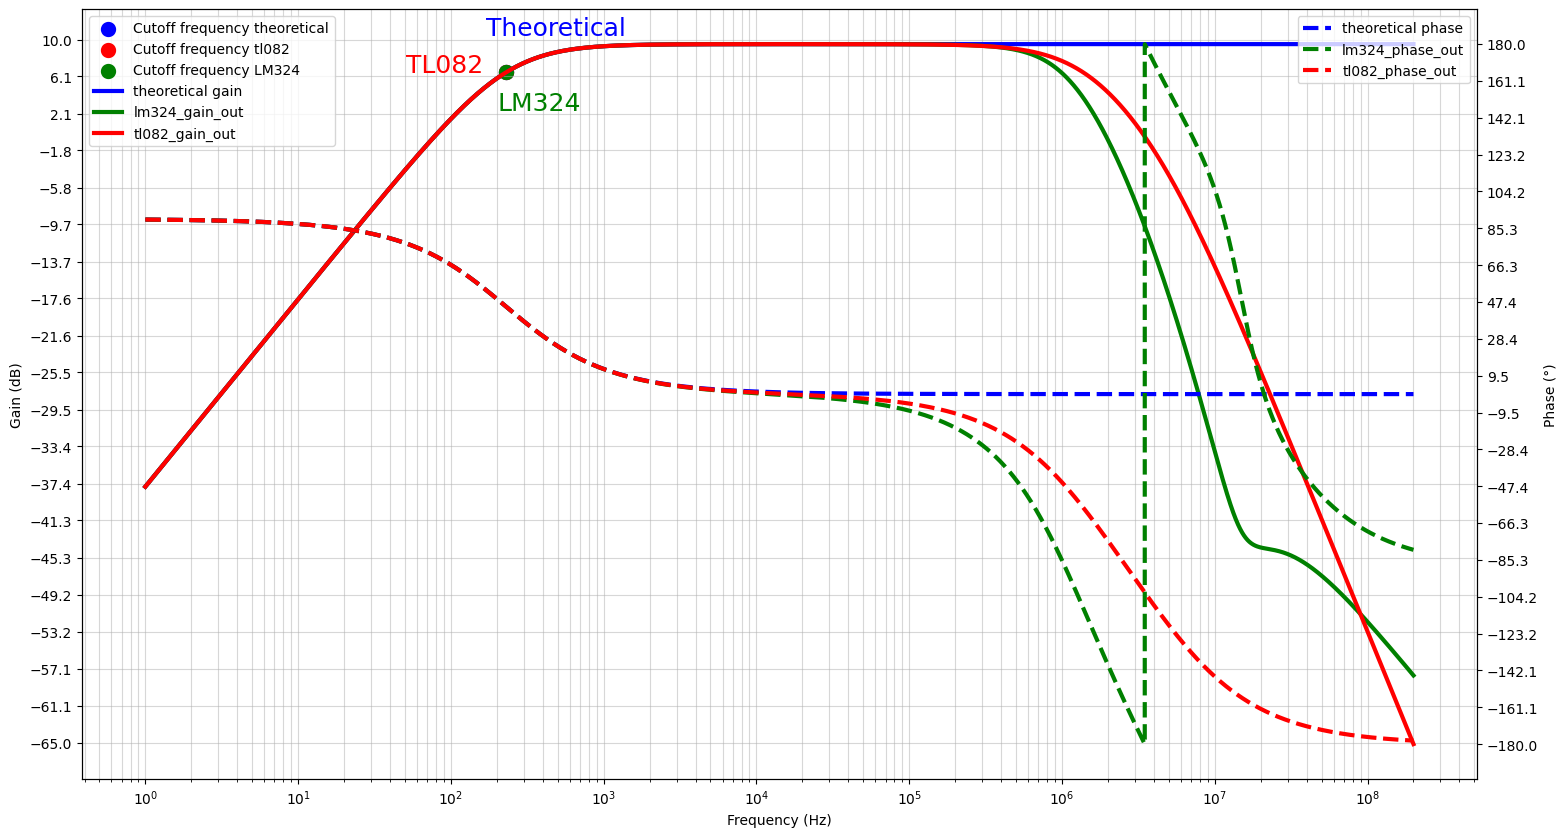

In [19]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))

linear_gain_theoretical = 3
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 230
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out")
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print("------------------------------GANHOS------------------------------\n")
print(f'Ganho Teórico (db)    : {round(gain_theoretical, 3)} db')
print(f'Ganho Teórico (linear): {round(linear_gain_theoretical, 3)}')
print(f'Ganho TL082   (db)    : {round(gain_tl082, 3)} db')
print(f'Ganho TL082   (linear): {round(log_2_linear(gain_tl082), 3)}')
print(f'Ganho LM324   (db)    : {round(gain_lm324, 3)} db')
print(f'Ganho LM324   (linear): {round(log_2_linear(gain_lm324), 3)}')
print()
print("-----------------------Frequências de corte-----------------------\n")
print_param("Frequência de corte teórica", cutoff_frequency_theoretical, "Hz")
print_param("Frequência de corte TL082  ", cutoff_frequency_tl082, "Hz")
print_param("Frequência de corte LM324  ", cutoff_frequency_lm324, "Hz")
print()
print("------------------Fases nas frequências de corte------------------\n")
print_param("Fase na frequência de corte teórica", 45, "°")
print_param("Fase na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Fase na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print()
print("------------------------Taxas de atenuação------------------------\n")
print_param("Taxa de atenuação teórica", 20, "db/dec")
print_param("Taxa de atenuação TL082  ", attenuation_ratio_tl082, "db/dec")
print_param("Taxa de atenuação LM324  ", attenuation_ratio_lm324, "db/dec")
print()
print("-----------------Ganhos nas frequências de corte------------------\n")
print_param("Ganho na frequência de corte teórica", gain_theoretical - 3, "db")
print_param("Ganho na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Ganho na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")
print()
print("------------------------------------------------------------------")

fig, ax = plt.subplots(figsize = (18, 10))
mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)
freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 - 180, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 30, get_cutoff_gain(gain_lm324) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0
)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)

### Análises dos valores obtidos acima

Como pode ser observado pela tabela de valores antes do grafico que é apresentado acima, não houve dispariedades grandes quanto aos valores entre as simulações e os comportamento teórico puro da função de transferência do filtro, porém vale ressaltar a seguinte observação:
* Quanto a fase, está possui uma diferença mesmo que pequena mas perceptivel, que depois nos próximos projetos ficará mais evidente, e isso é esperado e se deve ao fato de que os parasitas do AMPOP começaram a afetar a fase do filtro antes de seu ganho de saída com o aumento da frequência e como será mostrado posteriormente com a utilização de um ganho muito alto que irá aumentar o efeito desses parasitas devido a slew rate. Logo a fase é esperada que seja afetada antes do ganho de saída, mesmo que no exemplo anterior não seja tão perceptível.

Quanto a análise dos gráficos, deve-se ressaltar que condizem com o esperado, únicos pontos a serem observados é justamente o fato de a parte ativa do filtro, AMPOP estar influenciando na saída, como será discutido em análises posteriores, e que a fase começa a sofrer o efeito da frequência antes do ganho, fato que é esperado como mencionado no texte do ponto anterior.

<hr />

### Comparação do ganho antes e depois da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

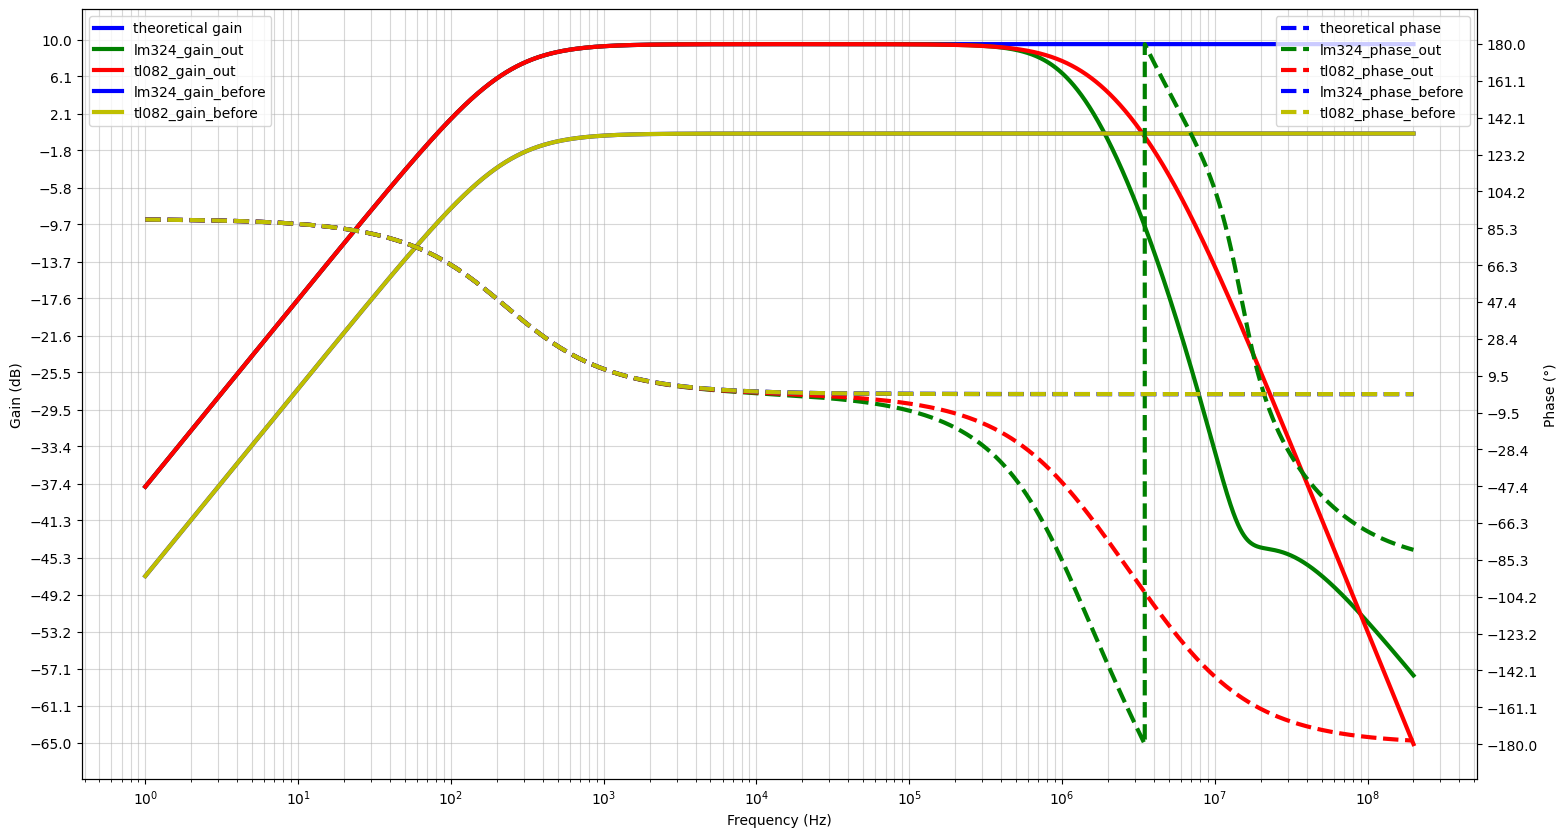

In [20]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))

theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)
mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")

### Análise da influência da parte ativa no filtro

O gráfico anterior é relativamente mais complexo de se entender a primeira vista pela a quantidade de curvas, porém este demonstra um fenômeno que era esperado e vale a pena ser analisado.

Para realizar a análise, começe apenas analisando as curvas de ganho e ignore a fase primeiramente, dessa forma fica mais simples de entender o que esta sendo demonstrado. Logo, serão 5 curvas para serem analisadas, no gráfico acima, as curvas [lm324_gain_before, tl082_gain_before] estão sobrepostas, o que é o comportamento esperado, pois ambas analisam exatamente o mesmo circuito, pois antes da parte ativa os circuitos são iguais, logo basta analisar apenas a curva amarela para verificar o comportamento antes da parte ativa. Quanto as curvas [lm324_gain_out, tl082_gain_out] elas representam o sinal "amarelo" [lm324_gain_before, tl082_gain_before] após passarem pelo bloco ativo, logo, é a curva "amarela" porém com um ganho linear de 3 ou de 9.542 db aplicado a esta. Porém existe uma disparedade que pode ser observada, a curva "amarela" segue praticamente constante após a frequência de corte 230 Hz ao passo que as curvas [lm324_gain_out, tl082_gain_out] seguem constante apenas até aproximadamente 1 MHz e depois iniciam um decaimento, isso se deve à influência que o AMPOP exerce no filtro, pois após uma certa frequência os parasitas do AMPOP sobrepassam seu comportamento ideal e o ganho e fase começam a serem afetados. Agora tem um ponto que vale ressaltar ainda na análise dos ganhos, a curva azul [theoretical_gain] segue constante tal como a curva "amarela" porém com um ganho linear de 3 ou de 9.542 db aplicado a esta, isso se deve ao fato de idealmente esse filtro usar um AMPOP ideal que não deveria varia seu comportamento com a frequência. Logo pode-se observar claramente a influencia que a parte ativa exerce no circuito.

Agora, a mesma análise, porém com pequenas variações pode ser efetuada para as curvas pontilhadas, a fase. O único ponto a se levar é que as fases teóricas e antes da parte ativa devem ser igauis, pois como utilizou-se uma topologia VCVS não era esperado defasamento na parte ativa, logo a fase da função de transferência teórica e a fase antes da parte ativa onde se desconsidera os efeitos de AMPOP devem ser iguais, o que é claramente visto no gráfico. Ao passo que quando se analisam as curvas [lm324_phase_out, tl082_phase_out] podemos ver uma influência grande da frequência, o que demonstra o esperado, que a parte ativa aplica uma defasagem conforme a frequência sobre, isso se deve ao fato de os componentes reais possuírem parasitas que conforme a frequência se tornam mais evidente que o comportamento ideal do próprio AMPOP.

Três notas a se evidenciar nesse ponto que o leitor deve manter:
* Como mencionado anteriormente, a fase começa a ser afetada antes que o ganho fato que pode ser observado no gráfico anteriror
* Outro ponto interessante a ser observado, é que próximo ao final do grafico, onde as frequências já estão na casa de 100 MHz para cima, os comportamentos de ganho dos AMPOPs começam a se assimilar, isso se deve principalmente que, nessa região os modelos de simulação não dão um foco tão grande, pois não é uma região muito útil de se analisar para esse tipo de AMPOP e também pq os parasitas ja estão muito mais evidentes que o próprio comportamento do AMPOP, assim fazendo com que fiquem próximos os ganhos nessa região para tanto o LM324 quanto o TL082
* Última observação é o fato de que o LM324 começa a decair um pouco antes do que o TL082, isso ja é esperado e pode ser visto no datasheet do frabricante tendo em vista que o produto ganho banda dos AMPOPs e a slew rate destes diferem, do datasheet da Texas Instruments, contido referencia no final deste documento:
  * TL082:
    * Gain Bandwidth (typ): 4 MHz
    * Slew Rate (typ): 13 V/μs
  * LM324
    * Gain Bandwidth (typ): 1.2 MHz
    * Gain Bandwidth (typ): 0.5 V/μs

### Implementação prática do circuito e análises

<img src="./assets/imgs/sld_14_0.png" />

Observações a serem notadas nesta parte:
* AMPOP utilizado TL082
* Alimentação utilizada no AMPOP - Vcc +15V Vee -15V
* Sinal de entrada selecionado 100mV, sinal real medido 102mV
* Erro cometido pela equipe, não foi feito a medição dos componentes utilizados, logo não se pode confirmar os valores que realmente foram utilizados na implementação prática real, mas os valores desejados eram de:
  *  C: 100nF
  * R1: 6.8 kΩ
  * R2: 10 kΩ
  * R3: 22 kΩ
* Medidas realizadas a partir o osciloscópio, total de 31 pontos analisados, valores coletados:
```
frequency,vipp,vopp,phase
1.00000000e+01,102e-3,14.2e-3,87.2
1.61560000e+01,102e-3,22.2e-3,86.6
2.61020000e+01,102e-3,35.5e-3,83.7
4.21700000e+01,102e-3,56.4e-3,78.9
6.81290000e+01,102e-3,88.8e-3,72.2
1.10069000e+02,102e-3,134e-3,63.0
1.77828000e+02,102e-3,188e-3,51.4
2.30e+02,102e-3,216e-3,44.01
2.50e+02,102e-3,224e-3,42.8
2.70e+02,102e-3,234e-3,39.3
2.87298000e+02,102e-3,238e-3,37.2
4.64159000e+02,102e-3,272e-3,26.7
7.49894000e+02,102e-3,288e-3,17.3
1.21152800e+03,102e-3,297e-3,10.9
1.95734200e+03,102e-3,300e-3,5
3.16227800e+03,102e-3,302e-3,2.95
5.10897000e+03,102e-3,302e-3,1.1
8.25404200e+03,102e-3,302e-3,-0.29
1.33352140e+04,102e-3,304e-3,-1.5
2.15443470e+04,102e-3,302e-3,-2.79
3.48070060e+04,102e-3,302e-3,-5.77
5.62341330e+04,102e-3,300e-3,-8.09
9.08517580e+04,102e-3,298e-3,-12.4
1.46779927e+05,102e-3,294e-3,-20.7
2.37137371e+05,102e-3,280e-3,-33.6
3.83118685e+05,102e-3,248e-3,-51.8
6.18965819e+05,102e-3,190e-3,-75.5
1.00000000e+06,102e-3,123e-3,-104
3.00000000e+06,102e-3,3.8e-3,-149
10.0000000e+06,106e-3,400e-6,-170
20.0000000e+06,40.8e-3,40e-6,-180
```
* Maior densidadde de pontos próximo da frequência de corte ideal de 230 Hz para permitir interpolação e análise mais fiel nessa região.
* Outro erro cometido pela equipe, como mencionado anteriormente, o circuito real implementado possuia uma frequência de corte de 234.05 Hz, porém a equipe fez a medição exata na frequencia de corte ideal do projeto que é de 230 Hz, logo a medida real no ponto 234.05 Hz foi perdida. Porém devido a densidade pontos nessa área foi possivel interpolar e encontrar onde seria a frequência de corte que provavelmente estaria ocorrendo no circuito real, isso será abordado nas análises a seguir.

<hr />

### Análise dos dados obtidos, interpolação e outros pontos a serem abordados

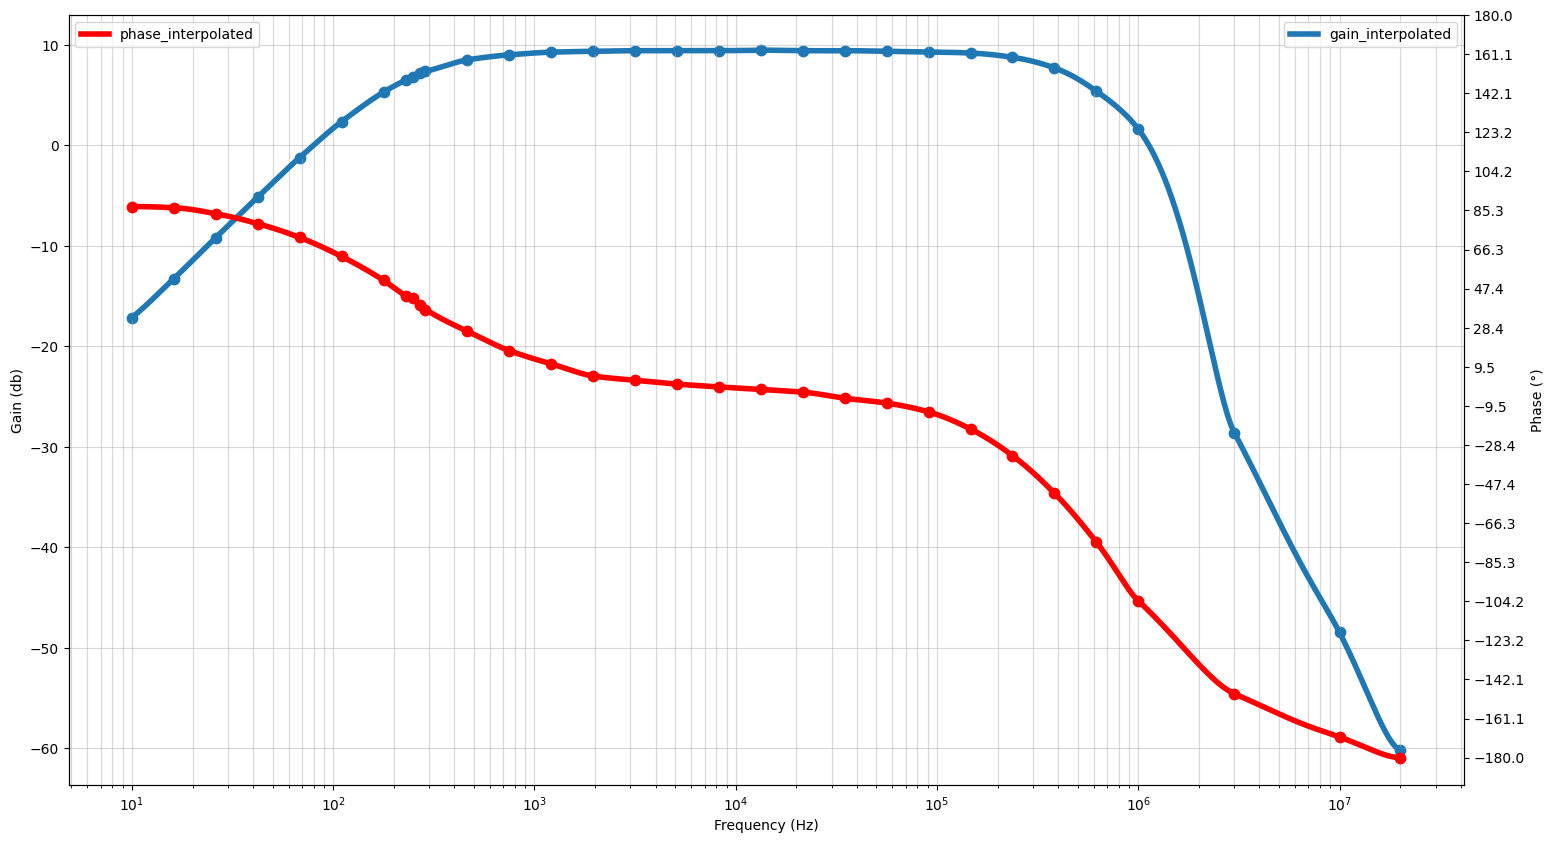

In [21]:
from scipy import interpolate

df_experiment = pd.DataFrame(
	pd.read_csv("./analises/pratica/pratica.csv", index_col = "frequency")
)
df_experiment["linear_gain"] = df_experiment["vopp"] / df_experiment["vipp"]
df_experiment["gain"] = linear_2_log(df_experiment["linear_gain"])


new_index = np.logspace(1, np.round(np.log10(20e6), 3), 61000)
interpolated_gain = interpolate.pchip_interpolate(
	df_experiment.index, df_experiment.gain, new_index
)
interpolated_phase = interpolate.pchip_interpolate(
	df_experiment.index, df_experiment.phase, new_index
)

fig, ax = plt.subplots(figsize = (18, 10))

# Plotting gain interpolation
df_experiment.reset_index().plot.scatter(ax = ax,x = "frequency" , y = ["gain"], linewidth = 4)
ax.plot(new_index, interpolated_gain, label = "gain_interpolated", lw = 4)

# Plotting phase interpolation
ax2 = ax.twinx()
df_experiment.reset_index().plot.scatter(ax = ax2,x = "frequency" , y = ["phase"], color = 'r', linewidth = 4)
ax2.plot(new_index, interpolated_phase, label = "phase_interpolated", color = 'r', lw = 4)

# configure X axis
ax.legend()
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Gain (db)")

ax2.legend(loc="upper left")
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)

# creating interpolated dataframe
df_experiment = pd.DataFrame(
	{
		"gain": interpolated_gain,
		"phase": interpolated_phase,
		"frequency": new_index
	},
)
df_experiment = df_experiment.set_index("frequency")


### Análise dos resultados obtidos do experimento

Primeiramente deve-se definir como o seguinte gráfico foi obtido e seu significado, pois este será utilizado posteriormente.

Para obtenção desse gráfico foi utilizado uma interpolação monotônica cubica para realizar a "ligação" entre os pontos obtidos no experimento descritos no texto antes do código acima. Essa interpolação foi aplicada para fase quanto para ganho. As curvas resultantes são ganho e fase sendo representadas respectivamentes pelas cores azul e vermelho. Os pontos que aparecem no gráfico são os pontos coletados no experimento.

Uma nota a se fazer nessa parte, é esperado normalmente que quando a frequência começe a ficar alta para esses AMPOPs, próximo da casa dos 100 MHz, que ocorra um leve aumento no ganho, fator observado inclusive por colegas que realizaram o experimento, mas essa informação não ocorre no grafico acima, isso se deve possivelmente a dois fatore:
* A densidade de pontos nessa região é baixa, logo pode-se ocorrer que os pontos coletados estejam nas extremidades ou fora dessa região e portanto a interpolação apenas "ignora" esse ocorrido pois esses dados não foram coletados.
* Como é apenas um comportamento parasíta que ocorre normalmete, pode ser que simplesmente não tenha ocorrido nessa situação, além que o sinal de entrada e saída se tratavam de idealmente 100mV e 300mV respectivamente, logo a slew rate não estava com um efeito muito grande e portanto pode não ter ocorrido esse comportamente. O ponto da slew rate será mencionado no final do trabalho, pois existem algumas notas a se fazerem sobre os experimentos.

### Comparação (TL082) - Teórica / Simulada / Prática

------------------------------GANHOS------------------------------

Ganho Teórico         (db)    : 9.542 db
Ganho Teórico         (linear): 3
Ganho TL082 (LTSpice) (db)    : 9.54 db
Ganho TL082 (LTSpice) (linear): 2.999
Ganho Experimento     (db)    : 9.485 db
Ganho Experimento     (linear): 2.98

-----------------------Frequências de corte-----------------------

Frequência de corte teórica         : 230 Hz
Frequência de corte TL082 (LTSpice) : 230.5 Hz
Frequência de corte Experimento     : 228.27 Hz

------------------Fases nas frequências de corte------------------

Fase na frequência de corte teórica         : 45°
Fase na frequência de corte TL082 (LTSpice) : 44.926°
Fase na frequência de corte Experimento     : 44.154°

------------------------Taxas de atenuação------------------------

Taxa de atenuação teórica         : 20 db/dec
Taxa de atenuação TL082 (LTSpice) : 19.528 db/dec
Taxa de atenuação Experimento     : 18.661 db/dec

-----------------Ganhos nas frequências de corte-

Text(0.5, 0, 'Frequency (Hz)')

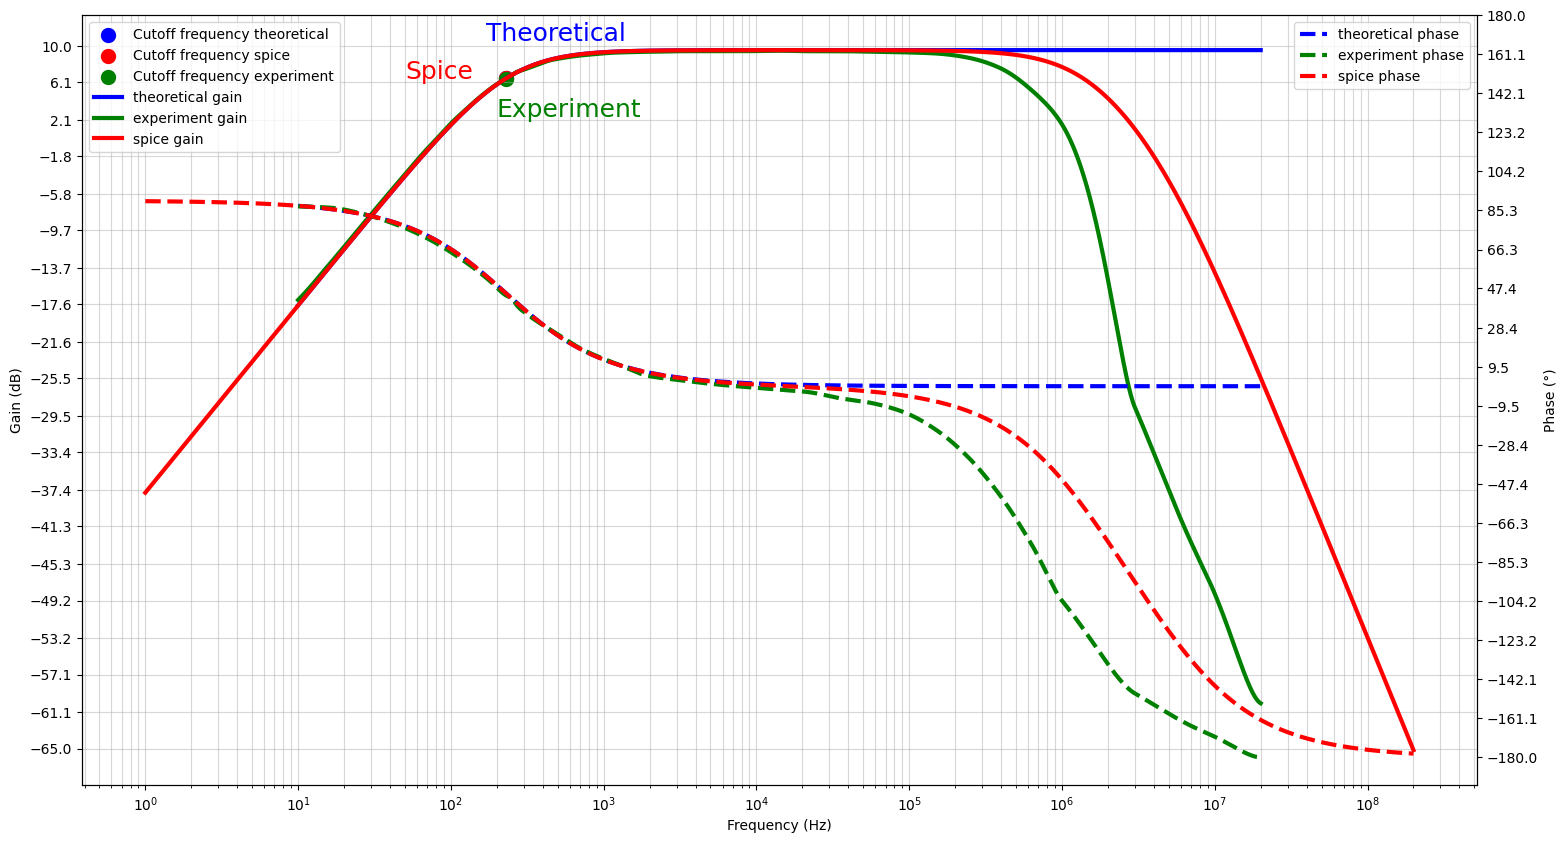

In [22]:
df_spice = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))

linear_gain_theoretical = 3
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_spice = get_gain(df_spice, "tl082_gain_out")
gain_experiment = get_gain(df_experiment, "gain")

cutoff_frequency_theoretical = 230
cutoff_frequency_spice = get_cutoff_frequency(df_spice, "tl082_gain_out")
cutoff_frequency_experiment = get_cutoff_frequency(df_experiment, "gain")

attenuation_ratio_spice = get_attenuation_ratio(df_spice, "tl082_gain_out")
attenuation_ratio_experiment = get_attenuation_ratio(df_experiment, "gain")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print("------------------------------GANHOS------------------------------\n")
print(f'Ganho Teórico         (db)    : {round(gain_theoretical, 3)} db')
print(f'Ganho Teórico         (linear): {round(linear_gain_theoretical, 3)}')
print(f'Ganho TL082 (LTSpice) (db)    : {round(gain_tl082, 3)} db')
print(f'Ganho TL082 (LTSpice) (linear): {round(log_2_linear(gain_tl082), 3)}')
print(f'Ganho Experimento     (db)    : {round(gain_experiment, 3)} db')
print(f'Ganho Experimento     (linear): {round(log_2_linear(gain_experiment), 3)}')
print()
print("-----------------------Frequências de corte-----------------------\n")
print_param("Frequência de corte teórica         ", cutoff_frequency_theoretical, "Hz")
print_param("Frequência de corte TL082 (LTSpice) ", cutoff_frequency_spice, "Hz")
print_param("Frequência de corte Experimento     ", cutoff_frequency_experiment, "Hz")
print()
print("------------------Fases nas frequências de corte------------------\n")
print_param("Fase na frequência de corte teórica         ", 45, "°")
print_param("Fase na frequência de corte TL082 (LTSpice) ", df_spice.loc[cutoff_frequency_spice]["tl082_phase_out"], "°")
print_param("Fase na frequência de corte Experimento     ", df_experiment.loc[cutoff_frequency_experiment]["phase"], "°")
print()
print("------------------------Taxas de atenuação------------------------\n")
print_param("Taxa de atenuação teórica         ", 20, "db/dec")
print_param("Taxa de atenuação TL082 (LTSpice) ", attenuation_ratio_spice, "db/dec")
print_param("Taxa de atenuação Experimento     ", attenuation_ratio_experiment, "db/dec")
print()
print("-----------------Ganhos nas frequências de corte------------------\n")
print_param("Ganho na frequência de corte teórica         ", gain_theoretical - 3, "db")
print_param("Ganho na frequência de corte TL082 (LTSpice) ", df_spice.loc[cutoff_frequency_spice]["tl082_gain_out"], "db")
print_param("Ganho na frequência de corte Experimento     ", df_experiment.loc[cutoff_frequency_experiment]["gain"], "db")
print()
print("------------------------------------------------------------------")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * df_experiment.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# Spice
ax.scatter(
	x = cutoff_frequency_spice,
	y = get_cutoff_gain(gain_spice),
	label = "Cutoff frequency spice",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"Spice",
	(cutoff_frequency_spice - 180, get_cutoff_gain(gain_spice)),
	color = 'r',
	fontsize = 18
)
ax.scatter(
	x = cutoff_frequency_experiment,
	y = get_cutoff_gain(gain_experiment),
	label = "Cutoff frequency experiment",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'Experiment',
	(cutoff_frequency_experiment - 30, get_cutoff_gain(gain_experiment) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

df_experiment.plot(
	ax = ax,
	y = ["gain"],
	label = ["experiment gain"],
	color = ["g"],
	lw = 3.0,
)

df_spice.plot(
	ax = ax,
	y = ["tl082_gain_out"],
	label = ["spice gain"],
	color = ["r"],
	lw = 3.0,
)


# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

df_experiment.plot(
	ax = ax2,
	y = ["phase"],
	label = ["experiment phase"],
	style = ["--"],
	color = ["g"],
	lw = 3.0
)

df_spice.plot(
	ax = ax2,
	y = ["tl082_phase_out"],
	label = ["spice phase"],
	style = ["--"],
	color = ["r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-65, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base=10)
ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=15))
ax.xaxis.set_minor_locator(LogLocator(
	base=10.0, subs=np.arange(0.1, 1.0, 0.1), numticks=150))
ax.set_xlabel("Frequency (Hz)")


### Da análise Teórico / Simulado / Prático

Primeiramente será feito uma análise dos resultados numéricos e posteriormente será feita uma análise do gráfico acima para gerar as conclusões.

Quanto aos resultados numéricos, pode-se observar que os resultados relacionados com os ganhos, tanto na frequência de corte quanto na região pós frequência de corte ficaram extremamente próximos ao teórico esperado.

------------------------------GANHOS------------------------------

* Ganho Teórico         (db)    : 9.542 db
* Ganho Teórico         (linear): 3
* Ganho TL082 (LTSpice) (db)    : 9.54 db
* Ganho TL082 (LTSpice) (linear): 2.999
* Ganho Experimento     (db)    : 9.485 db
* Ganho Experimento     (linear): 2.98

-----------------Ganhos nas frequências de corte------------------

* Ganho na frequência de corte teórica         : 6.5424 db
* Ganho na frequência de corte TL082 (LTSpice) : 6.541 db
* Ganho na frequência de corte Experimento     : 6.4854 db

Agora observando valores que possuíram dispariedades e alguns valores que podem ser enganosos, primeiramente quanto a própria frequência de corte, os valores obtidos são os seguinte:

-----------------------Frequências de corte-----------------------

* Frequência de corte teórica         : 230 Hz
* Frequência de corte TL082 (LTSpice) : 230.5 Hz
* Frequência de corte Experimento     : 228.27 Hz

Pequena observação a ser feita, esses valores, por se tratar de um filtro de primeira ordem, foram obtidos a partir das análises das curvas de/a [função de transferência para o teórico, pontos da simulação do spice para o simulado, curva da interpolação dos resultados medidos no experimento para o experimento]. Quanto a ánalise a ser realizada, pode-se observar quue o teórico e o spice acertam praticamente de forma exata a frequência de corte de projeto que se tratava de 230 Hz, e de primeira vista o experimento parece ser próximo desse valor, mas um ponto a ser lembrado é que o projeto do experimento não se trata do mesmo circuito que o simulado como mencionado anteriormente, mas sim de um circuito projetado para possuir uma frequência de corte de 234.05 Hz, logo o erro total de fase do experimento foi de 5.78 Hz. De forma geral, considerando que a equipe não realizou nenhum tipo de ajuste ou medição para seleção dos componentes, esse erro se trata de um valor aceitado, mas como mencionado na fase de projeto anteriormente, há necessidade da análise da aplicação que o filtro vai ser utilizado e dos requisitos, pois esse erro pode se tratar de algo desprezivel ou muito critico, mas esse tópico foi abordado melhor nas seções iniciais que tratavam do projeto do filtro. Um outro ponto interessante a se debater sobre a frequência de corte, é quanto ao range esperado quanto ao erro dos componentes, como mencionado na seção de projeto, as frequências comerciais MAX e MIN, que consideram os piores casos de erro de componentes, forneciam frequências de (MIN) 202.64 Hz e (MAX): 273.74 Hz para os componentes utilizados no projeto, assim existia um range de 71.1 Hz possível que a frequência de corte poderia estar, considerando os piores casos.

Agora da análise das fases em frequência de corte, os valores obtidos são os seguintes:

------------------Fases nas frequências de corte------------------

* Fase na frequência de corte teórica         : 45°
* Fase na frequência de corte TL082 (LTSpice) : 44.926°
* Fase na frequência de corte Experimento     : 44.154°

Como pode ser observado tanto a simulação quanto o experimento performaram relativamente bem nesse quesito, apesar que no experimento um erro de aproximadamente 0.9º ocorreu. Um dos fatores que pode ser descartado é slew rate e frequência, apesar de esses fatores influenciarem na fase, a frequência em questão é um valor baixo e que o AMPOP está ainda operando muito bem e quanto ao slew rate, tendo em vista que a entrada ideal estava em 100mV e saída em 300mV, são tensões confortáveis para esse AMPOP, logo os principais fatores que a equipe analisa que pode ter influenciado são:
* Parasitas da montagem, pouco provavel que tenham uma influência tão grande nessa frequência, mas precisam serem levados em consideração
* Aquisição do dado com precisão baixa, esse fator provavelmente possui mais influência nesse erro, como mencionado anteriormente a curva do experimento foi interpolada e essa medição se originou da curva interpolada, e apesar de a equipe ter feito uma densidade de pontos maior próximo a região de 230 Hz, não foi realizado em si medições para o circuito efetivo. Para tal deveria ter sido feito a aquisição do ponto em 234.05 Hz e após isso ter sido feito a medição dos componentes reais e a aquisição no ponto esperado real de frequência de corte para o circuito real implementado. Porém devido a esses erros a interpolação foi a fonte de dados usada e portanto pode ter inserido algum erro na aquisição dessa medida de fase.

Quanto as taxas de atenuação, os valores obitidos foram:

------------------------Taxas de atenuação------------------------

* Taxa de atenuação teórica         : 20 db/dec
* Taxa de atenuação TL082 (LTSpice) : 19.528 db/dec
* Taxa de atenuação Experimento     : 18.661 db/dec

Para essa análise, deve ser levado dois principais fatores que contribuem para esse erro, o primeiro é o mesmo ponto da fase e se deve ao erro inserido pela interpolação, que queira ou não insere uma pequena quantidade de erro, mas o ponto a mais a ser observado se trata da forma como é calculado a taxa de atenuação, esse ponto é interessante para se manter em mente porque irá afetar os cricuitos futuros e será relembrado, para fazer o cálculo da taxa de atenuação, a equipe utilizou a média das atenuações entre cada ponto e seu vizinho delimitado por uma região antes ou depois da frequência de corte, logo como mais próximo dos extremos tanto para frequência tendendo a um dos seguintes valores [0 Hz, infinito Hz, frequência de corte] irão ocorrer pequenas anormalidades nas atenuações, normalmente estas ficaram mais suaves e logo contribuirão para um valor médio mais suave, mesmo que o esperado normalmente seja o contrário, logo o erro dessa medida esta associado com o fato de a análise deste utilizar todo o dominio que deve ser análisado ao inves de apenas usar a região mais "linear" da rampa, isso será performado e demonstrado no projeto 4 onde os resultados serão mais errôneos, com erro de quase 15 db/dec, porém nesse experimento a análise foi feita no dominio todo que convém, logo é esperado um valor mais suave, porém que se manteve próximo dos 20 db/dec esperado. Isso conclui a análise dos dados numéricos, segue a análise do gráfico.

Da análise do gráfico, praticamente todos os pontos utilizados na análise do teŕocio / simulado podem ser repetidos para esse gráfico, logo as informações que convém analisar são:
* O comportamento do filtro se mantem muito próximo do esperado teórico e simulado até a região onde o AMPOP começa a influenciar, logo o filtro apresenta uma perfomance esperada nessa região.
* Como esperado, a fase começa a apresentar erros antes do ganho no experimento também, comportamento esperado e que inclusive fica mais evidente na prática devido aos parasítas.
* O modelo da simulação apresenta uma performance melhor que o experimento, outro ponto esperado, tendo em vista que o modelo não considera diversos fatores existentes na montagem prática, porém apresenta uma ótima aproximação.
* Algo que pode ser notado é que o modelo começa a ficar com um erro muito grande se comparado com o experimento em frequências mais altas, reforçando o ponto abordado anteriormente que os desenvolvedores do modelo não projetaram esse modelo com tanta precisão para frequẽncias altas, o que faz sentido tendo em vista que o AMPOP não foi projetado para ser utilizado com esse range de frequência.

<hr />

### Notas para os próximos projetos

Os projetos a seguir, ou seja, 2 / 3 / 4 não foram implementados ná prática, assim cabendo apenas as análises teóricas / simuladas. Portanto, nesse cenário os valores comerciais bem como os re-cálculos de frequências comerciais, apesar de apresentados podem ser desconsiderados e não serão análisados, porém as mesmas análises do projeto 1 quanto a esses tópicos podem ser aplicadas nesses valores pois estes estarão disponíveis nos projetos abaixo, logo o leitor é livre se quiser para analisar esses valores porém não convém as análises seguintes.

Muitas das análises serão reutilizadas do projeto 1 pois os filtros são muito similares, com exeção do projeto 4 que possuirá algumas mudanças.

<hr />

#### 2 - Filtro passa-alta de primeira ordem [gain = 29, cut = 230Hz] (VCVS)

### Requisitos de projeto

* Frequência de corte desejada: 230Hz
* Ganho linear: 29
* Topologia usada VCVS (Escolhida por não ser inversora)

### Circuito

(Prévia, leia a observação nessa seção do projeto 1 para entender o porque da prévia se necessário)

<img src="./analises/2/2.png"/>
<hr/>

### Analise teorica

In [23]:
# 1 - Projetar e simular um filtro passa-alta de primeira ordem [gain = 29, cut = 230Hz]

# Cut frequency in Hz
fc: float = 230

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 29

# First order
b: float = 1

print("------------------------------------------------------------------")
C_suggested = (10.0 / fc) * 1e-6
print_param("Capacitor Sugerido", C_suggested, "F")

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for C in get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = b / (wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print_param("Capacitor escolhido", C, "F")
print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("    - Ideal R1", R1, "Ω")
print_param("    - Ideal R2", R2, "Ω")
print_param("    - Ideal R3", R3, "Ω")
print()
print_param("    - Comercial R1", R1_commercial, "Ω")
print_param("    - Comercial R2", R2_commercial, "Ω")
print_param("    - Comercial R3", R3_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("    - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print("    - Comercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print("------------------------------------------------------------------")
print_param("Valor de frequência comercial      ", FC_commercial, "Hz")
print_param("Valor de frequência comercial (MIN)", FC_commercial_min, "Hz")
print_param("Valor de frequência comercial (MAX)", FC_commercial_max, "Hz")
print("------------------------------------------------------------------")

------------------------------------------------------------------
Capacitor Sugerido: 43.478 nF
Capacitor escolhido: 91 nF
------------------------------------------------------------------
Parâmetros do circuito: 
    - Ideal R1: 7.6042 kΩ
    - Ideal R2: 7.8757 kΩ
    - Ideal R3: 220.52 kΩ

    - Comercial R1: 7.5 kΩ
    - Comercial R2: 8.2 kΩ
    - Comercial R3: 220 kΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
    - Ideal:
	.param C=91n R1=7.6042k R2=7.8757k R3=220.52k
    - Comercial:
	.param C=91n R1=7.5k R2=8.2k R3=220k
------------------------------------------------------------------
Valor de frequência comercial      : 233.19 Hz
Valor de frequência comercial (MIN): 201.9 Hz
Valor de frequência comercial (MAX): 272.74 Hz
------------------------------------------------------------------


### Análise do comportamento do circuito na simulação realizada no LTSpice

Segunda observação, todas as simulações foram realizadas utilizando os componentes ideiais, ou seja, sem arredondar para os componenetes comerciais mais próximo, assim permitindo a análise do comportamento do filtro solicitado pelo projeto. Também notar que todas simulações foram realizadas com ambos os AMPOPS (Amplificadores operacionasi) [TL082, LM324] e seus modelos contidos no LTSpice.

### Da análise propriamente dita

O circuito simulado é o mesmo apresentado na introdução do projeto 2, segue novamente a imagem do circuito para relembrar o que está sendo simulado e medido.

<img src="./analises/2/2.png"/>

Quanto a forma que as análises são performadas, primeiramente o circuito e o ambiente de simulação são configurados com os seguintes parâmetros

#### Notas sobre a simulação efetuada no LTSpice presente na figura a seguir

Circuito:
 * C = 91nF
 * R1 = 7.6042 kΩ
 * R2 = 7.8757 kΩ
 * R3 = 220.52 kΩ

Parâmetros:
 * Alimentação do ampop:
	* Vcc = 15V Vee = -15V
 * Sinal de entrada:
	* Vpp = 100mV
	* Fase = 0°

Análise:
 * Transiente:
	* De 1Hz até 200MHz

Após isto é feita a medição nas labels efetuadas [TL082_Vbefore, LM324_Vbefore, TL082_Vout, LM324_Vout] que, neste circuito discutido em questão representam, Vbefore medida antes da parte ativa e Vout medida após a parte ativa do filtro. Com esses dados em mão é feito a exportação de um arquivo .csv com os valores e utilizando o codigo a seguir é realizado algumas análises para demonstrar os pontos requisitados pela atividade.

### Simulação

------------------------------GANHOS------------------------------

Ganho Teórico (db)    : 29.248 db
Ganho Teórico (linear): 29
Ganho TL082   (db)    : 29.23 db
Ganho TL082   (linear): 28.941
Ganho LM324   (db)    : 29.206 db
Ganho LM324   (linear): 28.859

-----------------------Frequências de corte-----------------------

Frequência de corte teórica: 230 Hz
Frequência de corte TL082  : 229.65 Hz
Frequência de corte LM324  : 228.51 Hz

------------------Fases nas frequências de corte------------------

Fase na frequência de corte teórica: 45°
Fase na frequência de corte TL082  : 44.933°
Fase na frequência de corte LM324  : 44.929°

------------------------Taxas de atenuação------------------------

Taxa de atenuação teórica: 20 db/dec
Taxa de atenuação TL082  : 19.531 db/dec
Taxa de atenuação LM324  : 19.534 db/dec

-----------------Ganhos nas frequências de corte------------------

Ganho na frequência de corte teórica: 26.248 db
Ganho na frequência de corte TL082  : 26.23 db
Ganho n

Text(0.5, 0, 'Frequency (Hz)')

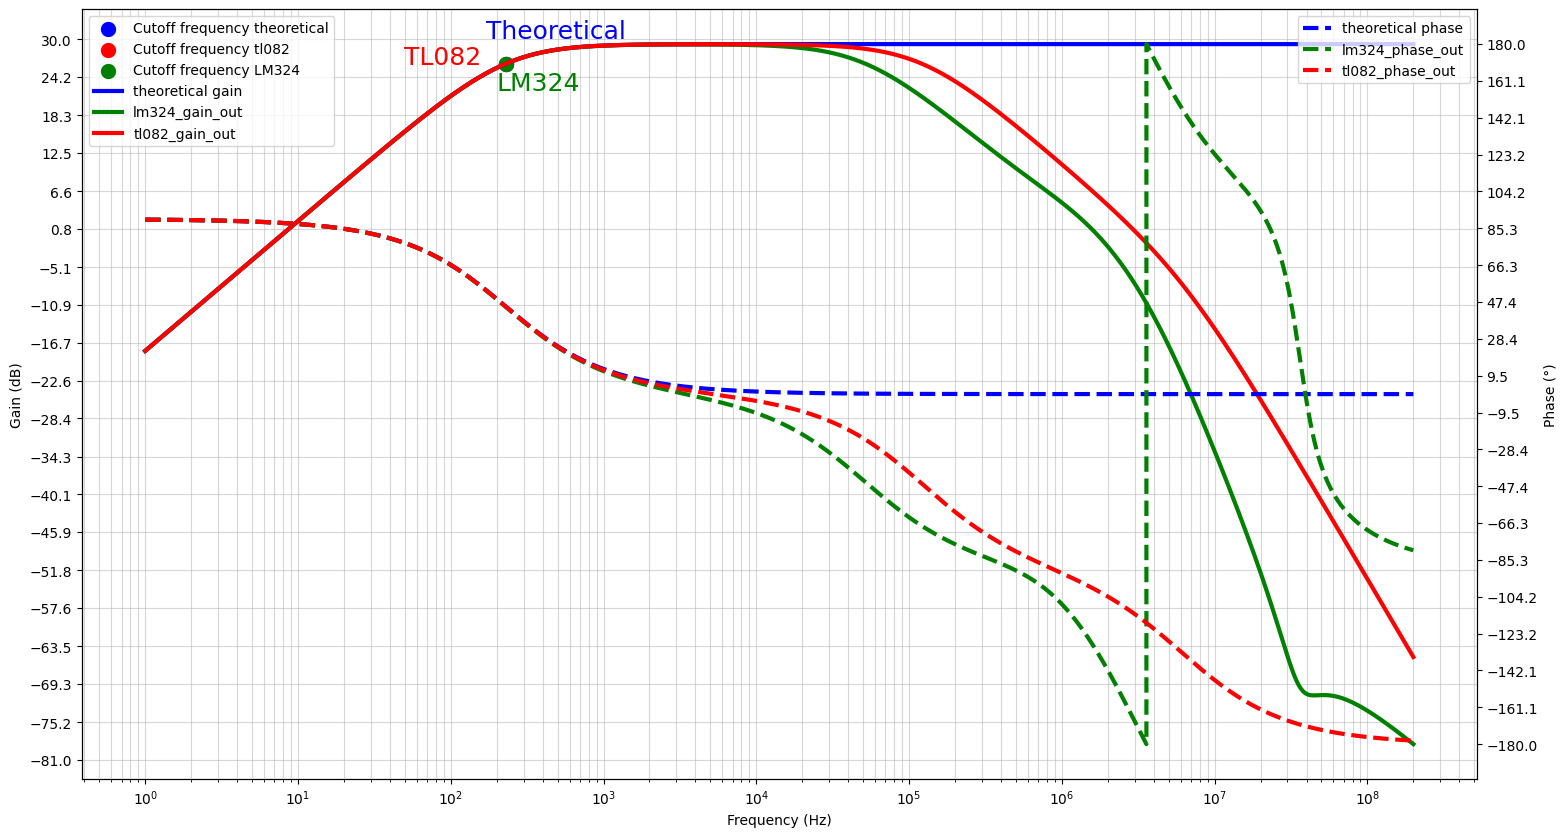

In [32]:
doc = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 230
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out")
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out")

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)

print("------------------------------GANHOS------------------------------\n")
print(f'Ganho Teórico (db)    : {round(gain_theoretical, 3)} db')
print(f'Ganho Teórico (linear): {round(linear_gain_theoretical, 3)}')
print(f'Ganho TL082   (db)    : {round(gain_tl082, 3)} db')
print(f'Ganho TL082   (linear): {round(log_2_linear(gain_tl082), 3)}')
print(f'Ganho LM324   (db)    : {round(gain_lm324, 3)} db')
print(f'Ganho LM324   (linear): {round(log_2_linear(gain_lm324), 3)}')
print()
print("-----------------------Frequências de corte-----------------------\n")
print_param("Frequência de corte teórica", cutoff_frequency_theoretical, "Hz")
print_param("Frequência de corte TL082  ", cutoff_frequency_tl082, "Hz")
print_param("Frequência de corte LM324  ", cutoff_frequency_lm324, "Hz")
print()
print("------------------Fases nas frequências de corte------------------\n")
print_param("Fase na frequência de corte teórica", 45, "°")
print_param("Fase na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Fase na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print()
print("------------------------Taxas de atenuação------------------------\n")
print_param("Taxa de atenuação teórica", 20, "db/dec")
print_param("Taxa de atenuação TL082  ", attenuation_ratio_tl082, "db/dec")
print_param("Taxa de atenuação LM324  ", attenuation_ratio_lm324, "db/dec")
print()
print("-----------------Ganhos nas frequências de corte------------------\n")
print_param("Ganho na frequência de corte teórica", gain_theoretical - 3, "db")
print_param("Ganho na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Ganho na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")
print()
print("------------------------------------------------------------------")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 60, get_cutoff_gain(gain_theoretical) + 4),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 - 180, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 30, get_cutoff_gain(gain_lm324) - 4),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


Mesmas análises do projeto 1 são aplicáveis para essa seção

<hr />

### Ganho antes da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

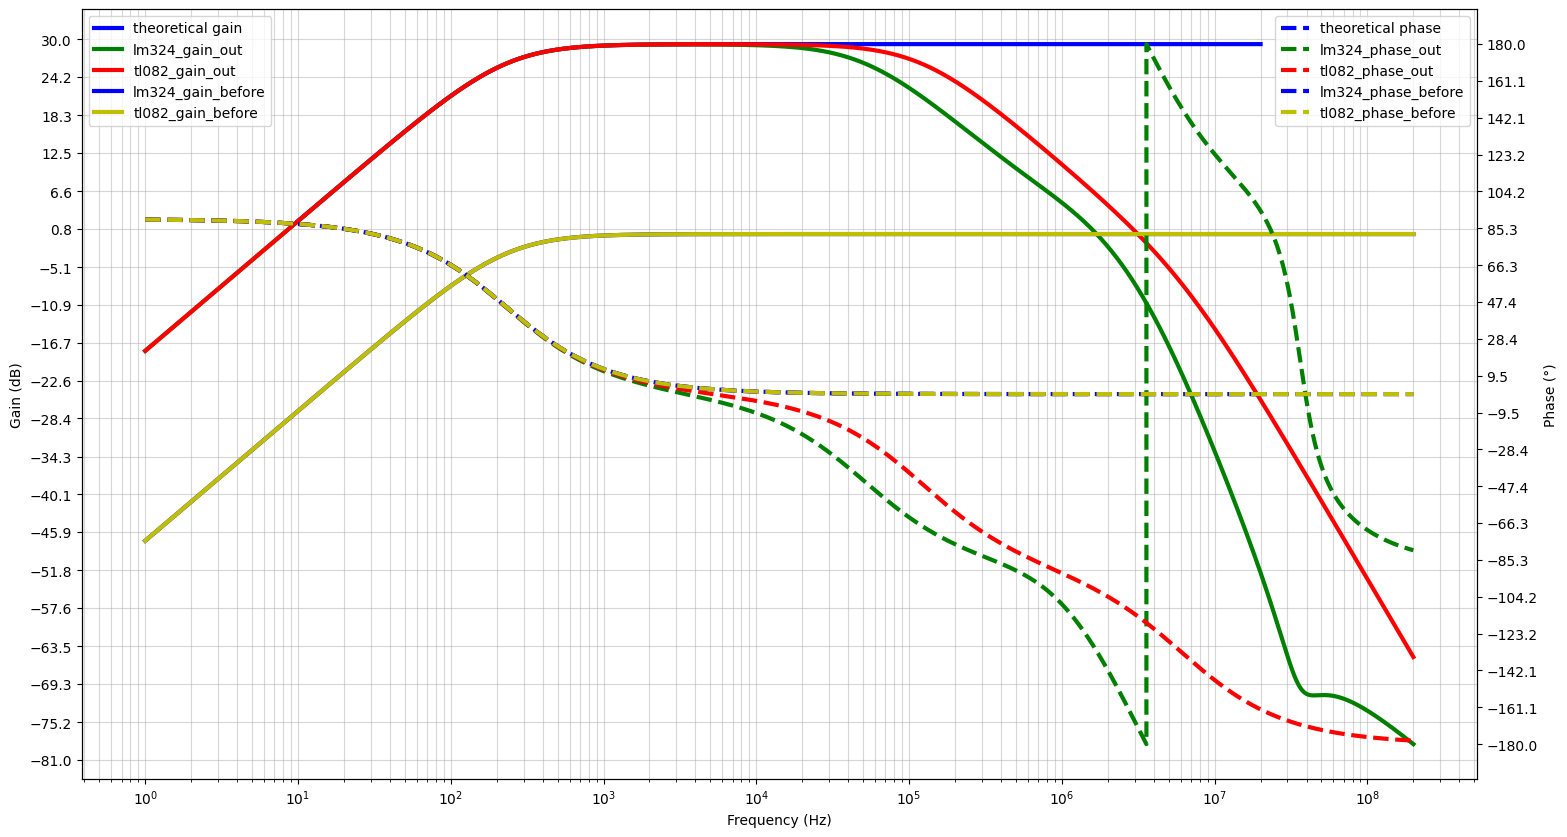

In [25]:
doc = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

theoretical_tf = get_n1_high_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)
mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * df_experiment.index)

freq = omega / (2 * np.pi)

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


Mesmas análises do projeto 1 são aplicáveis para essa seção

<hr />

### Comparação da influência do ganho

Text(0.5, 0, 'Frequency (Hz)')

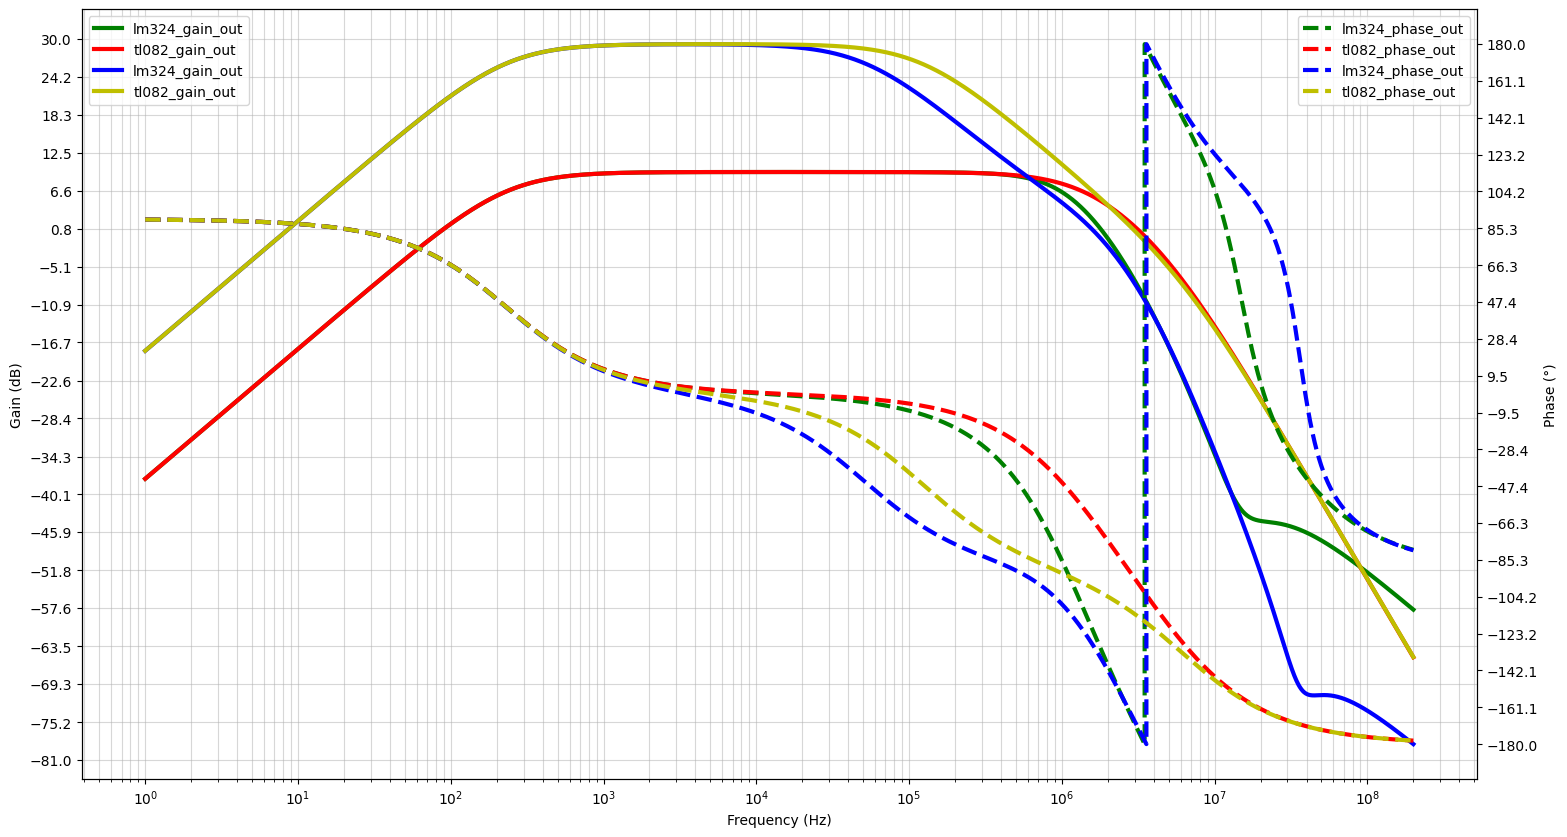

In [26]:
doc = pd.DataFrame(pd.read_csv("./analises/1/1.txt", index_col = "frequency"))
doc2 = pd.DataFrame(pd.read_csv("./analises/2/2.txt", index_col = "frequency"))

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)
doc2.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()
doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)
doc2.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(-81, 30, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")

### Análise entre os projetos 1 e 2

Como pode ser observado, todas as análises realizadas até o momento se conservam, porém em praticamente todas era apenas mencionado o fato de a frequência ser um fator decisivo na forma como o filtro performava, devido a sua parte ativa, porém o ponto principal a ser observado aqui, é que o ganho aplicado na parte ativa também possui uma relação com o quão rápido o filtro irá começar a desviar de seu comportamento esperado. Isso se deve ao produto ganho banda que é descrito nos datasheets e que já foi abordado anteriormente, porém como esperado, ao se aplicar um ganho maior, o AMPOP irá reduzir a frequência máxima que consegue operar antes de começar a apresentar parasístas evidentes. Isso pode ser claramente visto no gráfico acima, onde as curvas "amarela" e "azul" que representam o filtro com ganho linear 29, começam a cair muito antes das curvas "vermelha" e "verde" que representam o filtro com ganho linear 3. Assim fica evidente que o ganho também possui um papel na frequência máxima que o filtro conseguirá trabalhar. Por fim, vale ressaltar um ponto ja mencionado anteriormente, que ambos os filtros, tanto com ganho linear de 29 como 3, tendem ao mesmo ponto em altas frequências, no caso do gráfico acima, frequências acima de 100 MHz, isso se deve principalmente ao fato de os parasítas ja estarem muito mais evidentes que o próprio comportamento esperado do AMPOP e de que ambos circuitos dos filtros possuem os mesmos AMPOPs.

#### 3 - Filtro passa-baixa de primeira ordem [gain = 29, cut = 10kHz]

### Requisitos de projeto

* Frequência de corte desejada: 10 kHz
* Ganho linear: 29
* Topologia usada VCVS (Escolhida por não ser inversora)

### Circuito

(Prévia, leia a observação nessa seção do projeto 1 para entender o porque da prévia se necessário)

<img src="./analises/3/3.png"/>
<hr/>

### Analise Teorica

In [41]:
# 3 - Projetar e simular um filtro passa-baixa de primeira ordem [gain = 29, cut = 10kHz]

# Cut frequency in Hz
fc: float = 10e3

# Angular velocity
wc: float = 2 * np.pi * fc

# Linear gain
K: float = 29

# First order
b: float = 1

C_suggested = (10.0 / fc) * 1e-6
print_param("Capacitor Sugerido", C_suggested, "F")

# Searches for the best component fit cap
last_diff: int = 9999999
res: List[ float ] = []
for C in get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = 1 / (b * wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print_param("Capacitor escolhido", C, "F")
print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("    - Ideal R1", R1, "Ω")
print_param("    - Ideal R2", R2, "Ω")
print_param("    - Ideal R3", R3, "Ω")
print()
print_param("    - Comercial R1", R1_commercial, "Ω")
print_param("    - Comercial R2", R2_commercial, "Ω")
print_param("    - Comercial R3", R3_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("    - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print("    - Comercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C * R1_commercial)
FC_commercial_min = 1 / (np.pi * 2 * (C * 1.1) * (R1_commercial * 1.05))
FC_commercial_max = 1 / (np.pi * 2 * (C * 0.9) * (R1_commercial * 0.95))
print("------------------------------------------------------------------")
print_param("Valor de frequência comercial      ", FC_commercial, "Hz")
print_param("Valor de frequência comercial (MIN)", FC_commercial_min, "Hz")
print_param("Valor de frequência comercial (MAX)", FC_commercial_max, "Hz")
print("------------------------------------------------------------------")

Capacitor Sugerido: 1 nF
Capacitor escolhido: 9.1 nF
------------------------------------------------------------------
Parâmetros do circuito: 
    - Ideal R1: 1.749 kΩ
    - Ideal R2: 1.8114 kΩ
    - Ideal R3: 50.72 kΩ

    - Comercial R1: 1.8 kΩ
    - Comercial R2: 1.8 kΩ
    - Comercial R3: 51 kΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
    - Ideal:
	.param C=9.1n R1=1.749k R2=1.8114k R3=50.72k
    - Comercial:
	.param C=9.1n R1=1.8k R2=1.8k R3=51k
------------------------------------------------------------------
Valor de frequência comercial      : 9.7164 kHz
Valor de frequência comercial (MIN): 8.4125 kHz
Valor de frequência comercial (MAX): 11.364 kHz
------------------------------------------------------------------


### Análise do comportamento do circuito na simulação realizada no LTSpice

Segunda observação, todas as simulações foram realizadas utilizando os componentes ideiais, ou seja, sem arredondar para os componenetes comerciais mais próximo, assim permitindo a análise do comportamento do filtro solicitado pelo projeto. Também notar que todas simulações foram realizadas com ambos os AMPOPS (Amplificadores operacionasi) [TL082, LM324] e seus modelos contidos no LTSpice.

### Da análise propriamente dita

O circuito simulado é o mesmo apresentado na introdução do projeto 3, segue novamente a imagem do circuito para relembrar o que está sendo simulado e medido.

<img src="./analises/3/3.png"/>

Quanto a forma que as análises são performadas, primeiramente o circuito e o ambiente de simulação são configurados com os seguintes parâmetros

#### Notas sobre a simulação efetuada no LTSpice presente na figura a seguir

Circuito:
 *  C = 9.1 nF
 * R1 = 1.749 kΩ
 * R2 = 1.8114 kΩ
 * R3 = 50.72 kΩ

Parâmetros:
 * Alimentação do ampop:
	* Vcc = 15V Vee = -15V
 * Sinal de entrada:
	* Vpp = 100mV
	* Fase = 0°

Análise:
 * Transiente:
	* De 1Hz até 200MHz

Após isto é feita a medição nas labels efetuadas [TL082_Vbefore, LM324_Vbefore, TL082_Vout, LM324_Vout] que, neste circuito discutido em questão representam, Vbefore medida antes da parte ativa e Vout medida após a parte ativa do filtro. Com esses dados em mão é feito a exportação de um arquivo .csv com os valores e utilizando o codigo a seguir é realizado algumas análises para demonstrar os pontos requisitados pela atividade.

------------------------------GANHOS------------------------------

Ganho Teórico (db)    : 29.248 db
Ganho Teórico (linear): 29
Ganho TL082   (db)    : 29.247 db
Ganho TL082   (linear): 28.996
Ganho LM324   (db)    : 29.245 db
Ganho LM324   (linear): 28.99

-----------------------Frequências de corte-----------------------

Frequência de corte teórica: 10 kHz
Frequência de corte TL082  : 9.9073 kHz
Frequência de corte LM324  : 9.6194 kHz

------------------Fases nas frequências de corte------------------

Fase na frequência de corte teórica: -45°
Fase na frequência de corte TL082  : -49.513°
Fase na frequência de corte LM324  : -54.66°

------------------------Taxas de atenuação------------------------

Taxa de atenuação teórica: 20 db/dec
Taxa de atenuação TL082  : 38.962 db/dec
Taxa de atenuação LM324  : 38.98 db/dec

-----------------Ganhos nas frequências de corte------------------

Ganho na frequência de corte teórica: 26.248 db
Ganho na frequência de corte TL082  : 26.247 db
Gan

Text(0.5, 0, 'Frequency (Hz)')

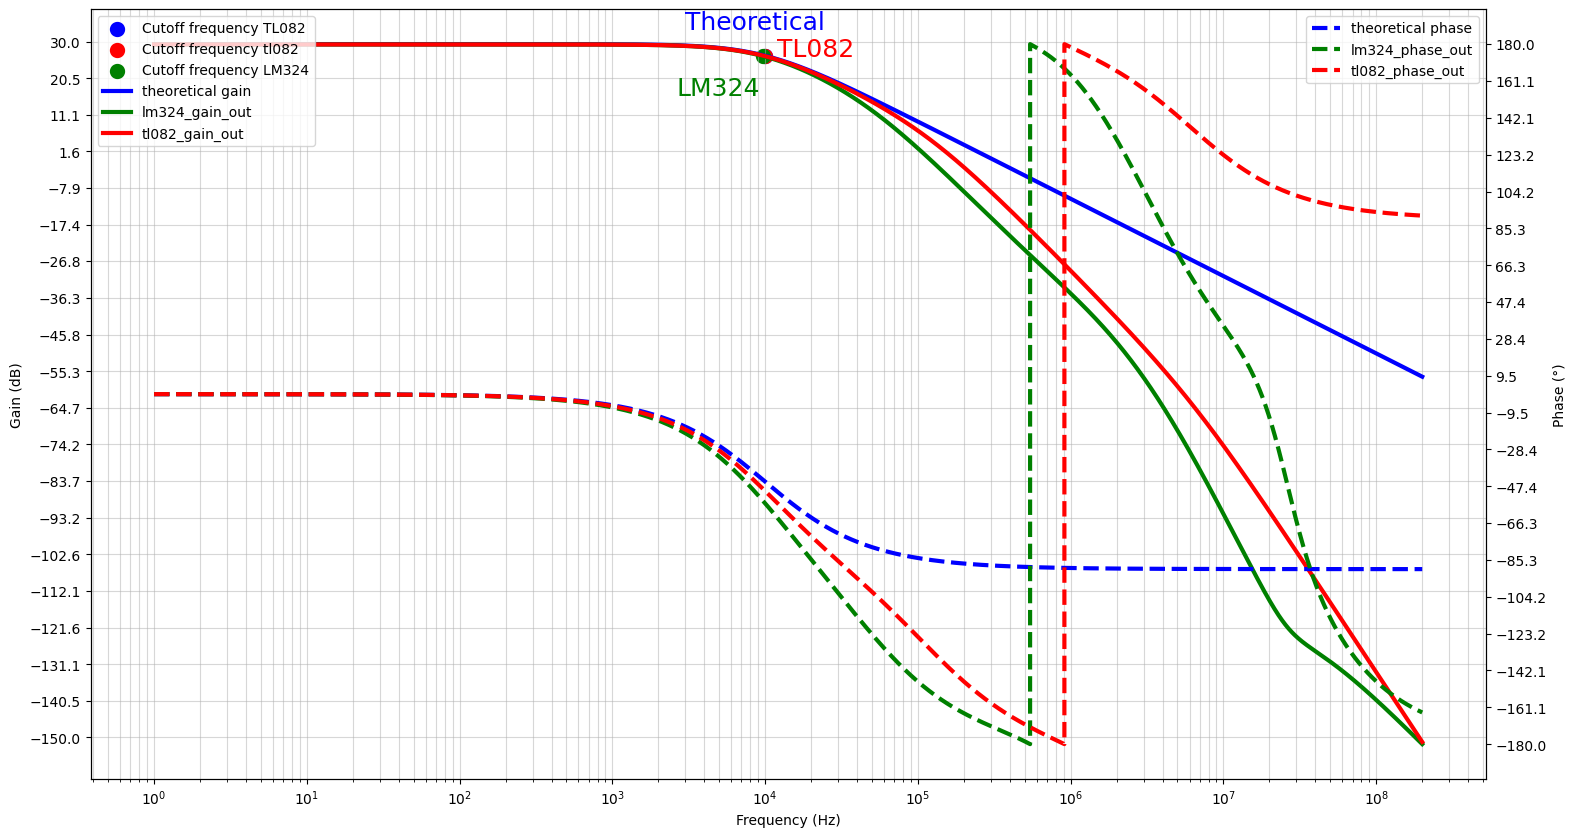

In [37]:
doc = pd.DataFrame(pd.read_csv("./analises/3/3.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain(doc, "tl082_gain_out")
gain_lm324 = get_gain(doc, "lm324_gain_out")

cutoff_frequency_theoretical = 10e3
cutoff_frequency_tl082 = get_cutoff_frequency(doc, "tl082_gain_out")
cutoff_frequency_lm324 = get_cutoff_frequency(doc, "lm324_gain_out")

attenuation_ratio_tl082 = get_attenuation_ratio(doc, "tl082_gain_out", False)
attenuation_ratio_lm324 = get_attenuation_ratio(doc, "lm324_gain_out", False)

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n1_low_pass_filter(cutoff_frequency_theoretical, gain_theoretical)

print("------------------------------GANHOS------------------------------\n")
print(f'Ganho Teórico (db)    : {round(gain_theoretical, 3)} db')
print(f'Ganho Teórico (linear): {round(linear_gain_theoretical, 3)}')
print(f'Ganho TL082   (db)    : {round(gain_tl082, 3)} db')
print(f'Ganho TL082   (linear): {round(log_2_linear(gain_tl082), 3)}')
print(f'Ganho LM324   (db)    : {round(gain_lm324, 3)} db')
print(f'Ganho LM324   (linear): {round(log_2_linear(gain_lm324), 3)}')
print()
print("-----------------------Frequências de corte-----------------------\n")
print_param("Frequência de corte teórica", cutoff_frequency_theoretical, "Hz")
print_param("Frequência de corte TL082  ", cutoff_frequency_tl082, "Hz")
print_param("Frequência de corte LM324  ", cutoff_frequency_lm324, "Hz")
print()
print("------------------Fases nas frequências de corte------------------\n")
print_param("Fase na frequência de corte teórica", -45, "°")
print_param("Fase na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Fase na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print()
print("------------------------Taxas de atenuação------------------------\n")
print_param("Taxa de atenuação teórica", 20, "db/dec")
print_param("Taxa de atenuação TL082  ", attenuation_ratio_tl082, "db/dec")
print_param("Taxa de atenuação LM324  ", attenuation_ratio_lm324, "db/dec")
print()
print("-----------------Ganhos nas frequências de corte------------------\n")
print_param("Ganho na frequência de corte teórica", gain_theoretical - 3, "db")
print_param("Ganho na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Ganho na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")
print()
print("------------------------------------------------------------------")

fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency TL082",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical - 7000, get_cutoff_gain(gain_theoretical) + 7),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 + 2000, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 7000, get_cutoff_gain(gain_lm324) - 10),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(30, -150, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Análises dos valores obtidos acima

As mesmas análises realizadas nessa seção do projeto 1 se aplicam aqui, porém alguns pontos são necessários de serem adicionados:
* Primeiramente, a frequência que os filtros estão operando de corte ja é relativamente maior, ou seja, 10 kHz, isso influencia, principalmente para o LM324 que possui um produto ganho banda menor.
* Segundo, como analisado anteriormente, ja foi observado que o ganho também infuencia no quão rapido o filtro irá começar a sofre efeito dos parasitas, e vale ressaltar que o filtro acima possui um ganho linear de 29, logo é esperado que a frequência máxima que este consiga operar ja seja mais baixa.
* Outro ponto interessante a ser analisado que fica mais evidente nesse filtro, é o erro na fase se manifestar antes que o erro de ganho, como pode ser observado principalmente no LM324 que ja está em uma região ruim, o ganho esperado na frequência de corte era de 26.248 e o LM324 apresentou um ganho na frequência de corte de 26.246, ou seja, muito próximo, porém a fase na frequência de corte esperada era de -45º, porém o LM324 apresentou uma fase na frequência de corte de -54.66°. Isso evidencia muito que a fase ja estava sendo muito afetada, mesmo que o ganho ainda estivesse relativamente estável.
* Último ponto a se notar, é quanto as frequências de corte estarem menores que o esperado de 10 kHz, sendo as encontradas de [9.9073 kHz, 9.6194 kHz] para o TL082 e o LM324 respectivamente e as taxas de atenuação serem maiores, sendo a esperada de 20 db/dec mas as encontradas em torno de 38.9 db/dec. Esses pontos na verdade são ambos consequências dos parasítas dos AMPOPs que ficam muito mais evidentes em altas frequências, assim somando o comportamento parasíta passa baixa do AMPOP com o ganho elevado no filtro, é realmente esperado que o sinal sofra um decaimento mais rápido, o que pode ser observado no gráfico, e pelo fato de esse decaimento ser mais rápido e começar em uma frequência menor que a frequência de corte isso afeta ambos, a frequência de coret e a taxa de atenuação.

### Comparação do ganho antes e depois da parte ativa

Text(0.5, 0, 'Frequency (Hz)')

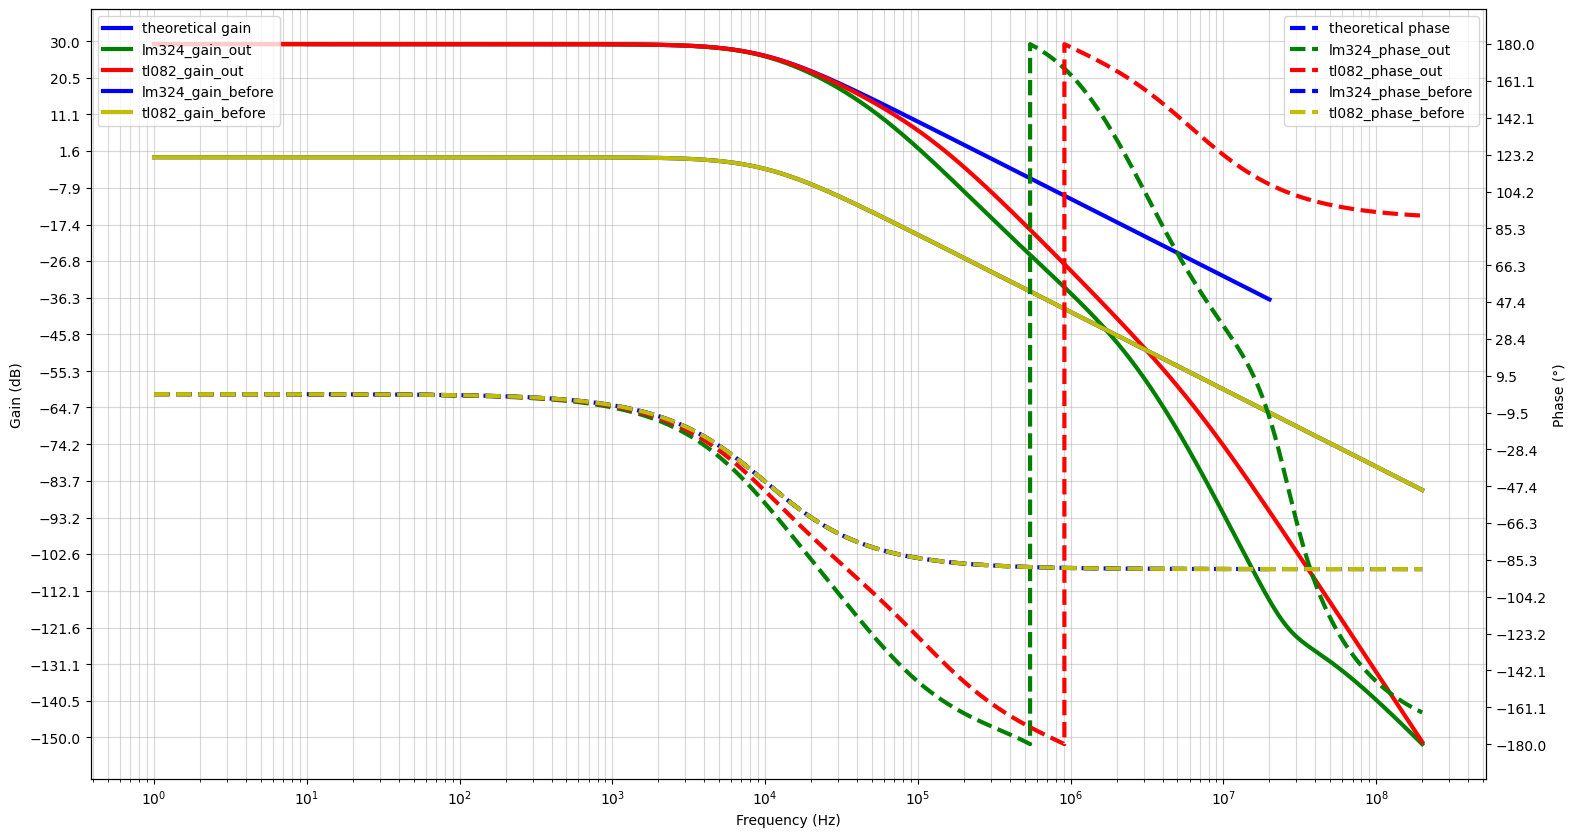

In [38]:
doc = pd.DataFrame(pd.read_csv("./analises/3/3.txt", index_col = "frequency"))

theoretical_tf = get_n1_low_pass_filter(cutoff_frequency_theoretical, linear_gain_theoretical)
mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * df_experiment.index)

freq = omega / (2 * np.pi)

fig, ax = plt.subplots(figsize = (18, 10))

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out", "lm324_gain_before", "tl082_gain_before"],
	color = ["g", "r", "b", "y"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out", "lm324_phase_before", "tl082_phase_before"],
	style = ["--", "--", "--", "--"],
	color = ["g", "r", "b", "y"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(30, -150, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Análise

(Mesmas análises nessa seção do projeto 1 cabem aqui)

Um único ponto a observar, é o quão evidente fica com essa comparação que a taxa de atenuação mais elevada que o normal, quase aproximando um filtro de segunda ordem, é um comportamento introduzido pela parte ativa do filtro, pois em um comportamento ideal e antes da parte ativa, ambas as curvas "azul" e "amarela" apresentam o comportamento esperado correto, porém as curvas "vermelha" e "verde" que, representam após a parte ativa, possuem um comportamento muito diferente de um filtro de primeira ordem, porém esperado que, inclusive nesse caso favorece o filtro em questão, pois se trata de um passa baixa que com essa taxa de atenuação mais elevada performa "melhor" em sua tarefa, porém a consequência implantada por esse parasíta é a frequência de corte ficar abaixo do esperado de 10 kHz.

#### 4 - Filtro passa-baixa de terceira ordem [gain = 29, cut = 10kHz] (VCVS)

### Requisitos de projeto

* Frequência de corte desejada: 10 kHz
* Ganho linear: 29
* Topologia usada VCVS (Escolhida por não ser inversora)

### Circuito

(Prévia, leia a observação nessa seção do projeto 1 para entender o porque da prévia se necessário)

<img src="./analises/4/4.png"/>
<hr/>

### Analise teorica

In [46]:
# 4 - Projetar e simular um filtro passa-baixa de terceira ordem 2db [gain = 29, cut = 10kHz]

# Cut frequency in Hz
fc: float = 10e3

# Angular velocity
wc: float = 2 * np.pi * fc

# Total gain
total_k: float = linear_2_log(29)
# Per stage gain
K: float = np.sqrt(total_k)

# First stage for 3dB
a0: float = 0.298620
b0: float = 0.839174

# Second stage for 3dB
a1: float = 0.298620

C_suggested = (10.0 / fc) * 1e-6
print_param("Capacitor Sugerido", C_suggested, "F")

#
# First stage low pass calcs order 2
#

# Searches for the best component fit cap
last_diff: int = 9999999
res: List[ float ] = []
for C in  get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	C2: float = C
	C1: float = (((a0 ** 2) + (4 * b0 * (K - 1))) * C2) / (4 * b0)
	C1_commercial: float = round_to_commercial(C1)

	aux = (((a0 ** 2) + (4 * b0 * (K - 1))) * (C2 ** 2)) - (4 * b0 * C1 * C2)

	if aux < 0:
		continue

	R1: float = 2.0 / (((a0 * C2) + np.sqrt(aux)) * wc)

	R2: float = 1.0 / (b0 * C1 * C2 * R1 * (wc ** 2))

	R3: float = (K * (R1 + R2)) / (K - 1)

	R4: float = K * (R1 + R2)

	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	R4_commercial = round_to_commercial(R4)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + \
        np.abs(R3_commercial - R3) + \
        np.abs(R4_commercial - R4) + np.abs(C1_commercial - C1)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C1, C2, R1, R2, R3, R4, R1_commercial, R2_commercial, R3_commercial, C1_commercial ]

# Fetches saved value
[ C1, C2, R1, R2, R3, R4, R1_commercial, R2_commercial, R3_commercial, C1_commercial ] = res

print("------------------------------------------------------------------")
print("Primeiro estágio (Passa baixa ordem 2)")
print_param("Capacitor escolhido C2", C2, "F")
print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("    - Ideal C1", C1, "Ω")
print_param("    - Ideal R1", R1, "Ω")
print_param("    - Ideal R2", R2, "Ω")
print_param("    - Ideal R3", R3, "Ω")
print_param("    - Ideal R4", R4, "Ω")
print()
print_param("    - Comercial C1", C1_commercial, "F")
print_param("    - Comercial R1", R1_commercial, "Ω")
print_param("    - Comercial R2", R2_commercial, "Ω")
print_param("    - Comercial R3", R3_commercial, "Ω")
print_param("    - Comercial R4", R4_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("    - Ideal:")
print(f"\t.param C1_0={Quantity(C1)} C2_0={Quantity(C2)} R1_0={Quantity(R1)} R2_0={Quantity(R2)} R3_0={Quantity(R3)} R4_0={Quantity(R4)}")
print("    - Comercial:")
print(f"\t.param C1_0={Quantity(C1_commercial)} C2_0={Quantity(C2)} R1_0={Quantity(R1_commercial)} R2_0={Quantity(R2_commercial)} R3_0={Quantity(R3_commercial)} R4_0={Quantity(R4_commercial)}")

# Seconds stage low pass calcs order 1

# Searches for the best component fit till 10nF cap
last_diff: int = 9999999
res: List[ float ] = []
for C in  get_EE_list(pack = get_EE_limit_from_value(C_suggested)):
	R1 = 1 / (b * wc * C)
	R3 = K * R1
	R2 = R3 / (K -1)
	R1_commercial = round_to_commercial(R1)
	R2_commercial = round_to_commercial(R2)
	R3_commercial = round_to_commercial(R3)
	total_diff = np.abs(R1_commercial - R1) + np.abs(R2_commercial - R2) + np.abs(R3_commercial - R3)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ]

# Fetches saved value
[ C, R1, R2, R3, R1_commercial, R2_commercial, R3_commercial ] = res

print("==================================================================")
print("Segundo estágio (Passa baixa ordem 1)")
print_param("Capacitor escolhido", C, "F")
print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("    - Ideal R1", R1, "Ω")
print_param("    - Ideal R2", R2, "Ω")
print_param("    - Ideal R3", R3, "Ω")
print()
print_param("    - Comercial R1", R1_commercial, "Ω")
print_param("    - Comercial R2", R2_commercial, "Ω")
print_param("    - Comercial R3", R3_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("    - Ideal:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1)} R2={Quantity(R2)} R3={Quantity(R3)}")
print("    - Comercial:")
print(f"\t.param C={Quantity(C)} R1={Quantity(R1_commercial)} R2={Quantity(R2_commercial)} R3={Quantity(R3_commercial)}")

Capacitor Sugerido: 1 nF
------------------------------------------------------------------
Primeiro estágio (Passa baixa ordem 2)
Capacitor escolhido C2: 6.8 nF
------------------------------------------------------------------
Parâmetros do circuito: 
    - Ideal C1: 30.156 nΩ
    - Ideal R1: 15.676 kΩ
    - Ideal R2: 93.904 Ω
    - Ideal R3: 19.347 kΩ
    - Ideal R4: 85.283 kΩ

    - Comercial C1: 33 nF
    - Comercial R1: 15 kΩ
    - Comercial R2: 91 Ω
    - Comercial R3: 18 kΩ
    - Comercial R4: 51 kΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
    - Ideal:
	.param C1_0=30.156n C2_0=6.8n R1_0=15.676k R2_0=93.904 R3_0=19.347k R4_0=85.283k
    - Comercial:
	.param C1_0=33n C2_0=6.8n R1_0=15k R2_0=91 R3_0=18k R4_0=51k
Segundo estágio (Passa baixa ordem 1)
Capacitor escolhido: 9.1 nF
------------------------------------------------------------------
Parâmetros do circuito: 
    - Ideal R1: 1.749 kΩ
    - Ideal R2: 2.1457 kΩ
    - Ide

### Análise do comportamento do circuito na simulação realizada no LTSpice

Todas as simulações foram realizadas utilizando os componentes ideiais, ou seja, sem arredondar para os componenetes comerciais mais próximo, assim permitindo a análise do comportamento do filtro solicitado pelo projeto. Também notar que todas simulações foram realizadas com ambos os AMPOPS (Amplificadores operacionasi) [TL082, LM324] e seus modelos contidos no LTSpice.

### Da análise propriamente dita

O circuito simulado é o mesmo apresentado na introdução do projeto 4, segue novamente a imagem do circuito para relembrar o que está sendo simulado e medido.

<img src="./assets/imgs/sld_37_0.png"/>
<img src="./analises/4/4.png"/>

Quanto a forma que as análises são performadas, primeiramente o circuito e o ambiente de simulação são configurados com os seguintes parâmetros

#### Notas sobre a simulação efetuada no LTSpice presente na figura a seguir

Circuito:
 * C = 91nF
 * R1 = 7.6042 kΩ
 * R2 = 7.8757 kΩ
 * R3 = 220.52 kΩ

Parâmetros:
 * Alimentação do ampop:
	* Vcc = 15V Vee = -15V
 * Sinal de entrada:
	* Vpp = 100mV
	* Fase = 0°

Análise:
 * Transiente:
	* De 1Hz até 200MHz

Após isto é feita a medição nas labels efetuadas [TL082_Vbefore, LM324_Vbefore, TL082_Vout, LM324_Vout] que, neste circuito discutido em questão representam, Vbefore medida entre bloco 1 e bloco 2 do filtro e Vout medida após o bloco 2 do filtro. Com esses dados em mão é feito a exportação de um arquivo .csv com os valores e utilizando o codigo a seguir é realizado algumas análises para demonstrar os pontos requisitados pela atividade.

### Simulação

------------------------------GANHOS------------------------------

Ganho Teórico (db)    : 29.248 db
Ganho Teórico (linear): 29
Ganho TL082   (db)    : 29.427 db
Ganho TL082   (linear): 29.602
Ganho LM324   (db)    : 29.477 db
Ganho LM324   (linear): 29.774

-----------------------Frequências de corte-----------------------

Frequência de corte teórica: 10 kHz
Frequência de corte TL082  : 10.347 kHz
Frequência de corte LM324  : 8.9315 kHz

------------------Fases nas frequências de corte------------------

Fase na frequência de corte teórica: 134.82°
Fase na frequência de corte TL082  : 151.45°
Fase na frequência de corte LM324  : 131.71°

------------------------Taxas de atenuação------------------------

Taxa de atenuação 20kHz - 100kHz teórica: 56.709 db/dec
Taxa de atenuação 20kHz - 100kHz TL082  : 61.216 db/dec
Taxa de atenuação 20kHz - 100kHz LM324  : 67.707 db/dec

Taxa de atenuação 20kHz - 20MHz teórica: 59.177 db/dec
Taxa de atenuação 20kHz - 20MHz TL082  : 48.999 db/dec
Taxa

Text(0.5, 0, 'Frequency (Hz)')

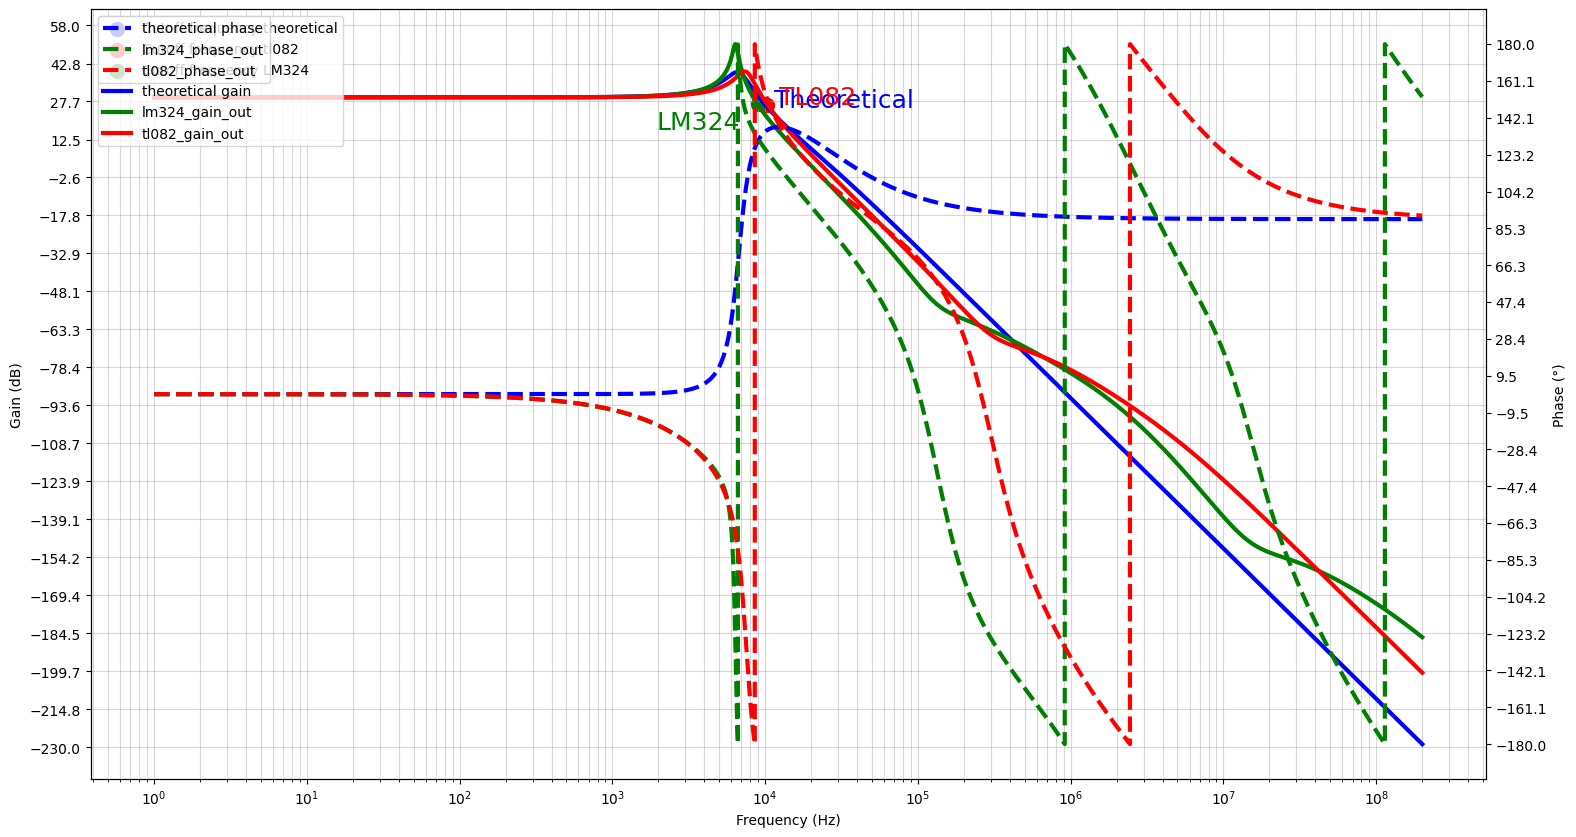

In [44]:
doc = pd.DataFrame(pd.read_csv("./analises/4/4.txt", index_col = "frequency"))

linear_gain_theoretical = 29
gain_theoretical = linear_2_log(linear_gain_theoretical)
gain_tl082 = get_gain_in_range(doc, "tl082_gain_out", 10, 1000)
gain_lm324 = get_gain_in_range(doc, "lm324_gain_out", 10, 1000)

cutoff_frequency_theoretical = 10e3
cutoff_frequency_tl082 = get_cutoff_frequency_in_range(doc, "tl082_gain_out", 10, 1000)
cutoff_frequency_lm324 = get_cutoff_frequency_in_range(doc, "lm324_gain_out", 10, 1000)

# Create transfer function of the theoretical behavior 
theoretical_tf = get_n3_low_pass_filter(10 ** 4, gain_theoretical, 1)

mag, phase, omega = theoretical_tf.frequency_response(2 * np.pi * doc.index)

freq = omega / (2 * np.pi)

theoretical_data = pd.DataFrame(
	{ "frequency": freq, "gain": linear_2_log(mag), "phase": np.rad2deg(phase) }
).set_index("frequency")

attenuation_ratio_theoretical = get_attenuation_ratio_in_range(theoretical_data, "gain", cutoff_frequency_theoretical * 2, cutoff_frequency_theoretical * 10)
attenuation_ratio_tl082 = get_attenuation_ratio_in_range(doc, "tl082_gain_out", cutoff_frequency_theoretical * 2, cutoff_frequency_theoretical * 10)
attenuation_ratio_lm324 = get_attenuation_ratio_in_range(doc, "lm324_gain_out", cutoff_frequency_theoretical * 2, cutoff_frequency_theoretical * 10)

print("------------------------------GANHOS------------------------------\n")
print(f'Ganho Teórico (db)    : {round(gain_theoretical, 3)} db')
print(f'Ganho Teórico (linear): {round(linear_gain_theoretical, 3)}')
print(f'Ganho TL082   (db)    : {round(gain_tl082, 3)} db')
print(f'Ganho TL082   (linear): {round(log_2_linear(gain_tl082), 3)}')
print(f'Ganho LM324   (db)    : {round(gain_lm324, 3)} db')
print(f'Ganho LM324   (linear): {round(log_2_linear(gain_lm324), 3)}')
print()
print("-----------------------Frequências de corte-----------------------\n")
print_param("Frequência de corte teórica", cutoff_frequency_theoretical, "Hz")
print_param("Frequência de corte TL082  ", cutoff_frequency_tl082, "Hz")
print_param("Frequência de corte LM324  ", cutoff_frequency_lm324, "Hz")
print()
print("------------------Fases nas frequências de corte------------------\n")
print_param("Fase na frequência de corte teórica", theoretical_data.loc[get_cutoff_frequency_in_range(theoretical_data, "gain", 10, 1000)]["phase"], "°")
print_param("Fase na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_phase_out"], "°")
print_param("Fase na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_phase_out"], "°")
print()
print("------------------------Taxas de atenuação------------------------\n")
print_param("Taxa de atenuação 20kHz - 100kHz teórica", attenuation_ratio_theoretical, "db/dec")
print_param("Taxa de atenuação 20kHz - 100kHz TL082  ", attenuation_ratio_tl082, "db/dec")
print_param("Taxa de atenuação 20kHz - 100kHz LM324  ", attenuation_ratio_lm324, "db/dec")
print()
print_param("Taxa de atenuação 20kHz - 20MHz teórica", get_attenuation_ratio_in_range(theoretical_data, "gain", cutoff_frequency_theoretical * 2, 20e6), "db/dec")
print_param("Taxa de atenuação 20kHz - 20MHz TL082  ", get_attenuation_ratio_in_range(doc, "tl082_gain_out", cutoff_frequency_theoretical * 2, 20e6), "db/dec")
print_param("Taxa de atenuação 20kHz - 20MHz LM324  ", get_attenuation_ratio_in_range(doc, "lm324_gain_out", cutoff_frequency_theoretical * 2, 20e6), "db/dec")
print()
print("-----------------Ganhos nas frequências de corte------------------\n")
print_param("Ganho na frequência de corte teórica", gain_theoretical - 3, "db")
print_param("Ganho na frequência de corte TL082  ", doc.loc[cutoff_frequency_tl082]["tl082_gain_out"], "db")
print_param("Ganho na frequência de corte LM324  ", doc.loc[cutoff_frequency_lm324]["lm324_gain_out"], "db")
print()
print("------------------------------------------------------------------")

fig, ax = plt.subplots(figsize = (18, 10))

# Plot cutoff frequencies
# Theoretical
ax.scatter(
	x = cutoff_frequency_theoretical,
	y = get_cutoff_gain(gain_theoretical),
	label = "Cutoff frequency theoretical",
	color = 'b',
	linewidths = 5
)
ax.annotate(
	"Theoretical",
	(cutoff_frequency_theoretical + 1500, get_cutoff_gain(gain_theoretical) - 1),
	color = 'b',
	fontsize = 18
)
# TL082
ax.scatter(
	x = cutoff_frequency_tl082,
	y = get_cutoff_gain(gain_tl082),
	label = "Cutoff frequency tl082",
	color = 'r',
	linewidths = 5
)
ax.annotate(
	"TL082",
	(cutoff_frequency_tl082 + 2000, get_cutoff_gain(gain_tl082)),
	color = 'r',
	fontsize = 18
)
# LM324
ax.scatter(
	x = cutoff_frequency_lm324,
	y = get_cutoff_gain(gain_lm324),
	label = "Cutoff frequency LM324",
	color = 'g',
	linewidths = 5
)
ax.annotate(
	'LM324',
	(cutoff_frequency_lm324 - 7000, get_cutoff_gain(gain_lm324) - 10),
	color = 'g',
	fontsize = 18
)

# plot gain
ax.plot(
	freq,
	linear_2_log(mag),
	label = "theoretical gain",
	color = "b",
	linewidth = 3.0
)

doc.plot(
	ax = ax,
	y = ["lm324_gain_out", "tl082_gain_out"],
	color = ["g", "r"],
	lw = 3.0,
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	freq,
	np.rad2deg(np.array(phase)),
	label = "theoretical phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

doc.plot(
	ax = ax2,
	y = ["lm324_phase_out", "tl082_phase_out"],
	style = ["--", "--"],
	color = ["g", "r"],
	lw = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_yticks(np.round(np.linspace(58, -230, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)
ax.set_xlabel("Frequency (Hz)")


### Análise

A primeira vista o gráfico pode ser complexo de analisar, porém será realizado posteriormente uma análise mais detalhada do gráfico. Agora será focado em uma análise dos resultados numéricos obtidos primeiro.

Observação para ser feita antes das análises, o valor do ganho na frequência de corte de um filtro chebyshev não é definido como o ganho na "banda passante" - 3 db, isso se deve ao seu ripple e o cálculo da frequência de corte para esse tipo de filtro normalmente exige que a frequência de corte seja isolada através da função de transferência, porém no caso onde o ripple é de 3 db, a convenção de ganho na "banda passante" - 3 db pode ser utilizada para aproximar, portanto o filtro projetado pela a equipe possui um ripple de 3 db, para permitir que a frequência de corte seja encontrada e não que seja chutado que o filtro está com a frequência correta em 10 kHz.

Segundo ponto a ser notado é o fato de a função de transferencia utilizada pela equipe apresentar um comportamento de fase invertido, isso acaba que não afeta muito os cálculos bem como a análise, porém tem de ser cauteloso ao analisar os graficos, isso será mencionado depois, mas de forma simplificada a função de transferência teórica possui comportamento correto de ganho mas a sua fase vai ao contrário do valor esperado mas de forma simétrica então continua podendo ser utilizada para viés de cálculos.

Da análise dos valores:

Quanto aos ganhos na região onde a frequência ainda não ultrapassou a frequência de corte, os valores simulados e teóricos são próximos, sendo os simulados um pouco maiores que o teórico, o que é esperado devido ao ripple que o filtro chebyshev insere na função de transferência.

------------------------------GANHOS------------------------------

* Ganho Teórico (db)    : 29.248 db
* Ganho Teórico (linear): 29
* Ganho TL082   (db)    : 29.427 db
* Ganho TL082   (linear): 29.602
* Ganho LM324   (db)    : 29.477 db
* Ganho LM324   (linear): 29.774

Quanto as frequências de corte, no geral o AMPOP LM324 performou de forma pobre nesse quesito, porém foi algo esperado devido ao ganho extremo aplicado a este, a frequência de corte e principalmente o ripple do filtro que aproxima um ganho de 40 db que para o LM324 resultou em uma frequência de corte de quase 1 kHz abaixo do esperado. O ripple e o ponto de operação são os fatores principais, pois o ripple eleva muito o ganho do filtro nessa região, e como observado anteriormente, o ganho alto influencia na queda antecipada do comportamento esperado do filtro.

-----------------------Frequências de corte-----------------------

* Frequência de corte teórica: 10 kHz
* Frequência de corte TL082  : 10.347 kHz
* Frequência de corte LM324  : 8.9315 kHz


# Colocar nota sobre slew rate

### Referências

Bibliografia Básica 

SEDRA, A. S; SMITH, K. C. Microeletrônica. 5.ed. São Paulo: Pearson / Prentice-Hall, 2010. 

BOYLESTAD, R. L.; NASHELSKY, L. Dispositivos Eletrônicos e Teoria de Circuitos. 8.ed. São Paulo: Prentice Hall, 2005. 

Bibliografia Complementar 

BOGART Jr, T. F. Dispositivos e Circuitos Eletrônicos. Vol. 2. São Paulo: Makron Books do Brasil, 2008 

PERTENCE Jr. , A. Amplificadores Operacionais e Filtros Ativos. 7.ed. Porto Alegre: Artmed, 2012.  

MALVINO, A. P. Eletrônica, Vol. 2. São Paulo:  MAKRON Books do Brasil, 1986. 

MILLMAN, J. e HALKIAS, C. C. Eletrônica: dispositivos e circuitos. Vol. 2. São Paulo : McGraw-Hill do Brasil, 1981. 

MARQUES, A. E. B. e outros. Dispositivos semicondutores: diodos e transistores. São Paulo: Editora Érica, 1996. 

Datasheet TL082 Texas Instruments:
 * https://www.ti.com/lit/ds/symlink/tl082-n.pdf?ts=1681630182190&ref_url=https%253A%252F%252Fwww.google.com%252F
 * Accessado em 16 de abril de 2023

Datasheet LM324 Texas Instruments:
 * https://www.ti.com/lit/ds/symlink/lm324.pdf?ts=1681598827622&ref_url=https%253A%252F%252Fwww.ti.com%252Fproduct%252FLM324%253Futm_source%253Dgoogle%2526utm_medium%253Dcpc%2526utm_campaign%253Dti-null-null-xref-cpc-pf-google-wwe%2526utm_content%253Dxref%2526ds_k%253D%257B_dssearchterm%257D%2526DCM%253Dyes%2526gclid%253DEAIaIQobChMI57Hg0_us_gIVbpBoCR2wUwhfEAAYASAAEgJOBPD_BwE%2526gclsrc%253Daw.ds
 * Accessado em 16 de abril de 2023